# Long Term Test

In [1]:
%run nb-env.ipynb

[2022-06-21T23:32:36.841466+08:00] Enviroment loaded. Working Dir: /Users/tzhu/work/lab/neo_world/notebooks
Today is 2022-06-21, Working from 2021-06-02 to 2022-06-21


KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
%%time

ori_start_date='2018-02-01' # before drop na

# from 2018-08-02 to the last auction date
# start_date='2018-08-02'
# end_date='2021-04-22'

# from cyb starts
start_date = '2020-08-24'
end_date = '2022-06-17'

dc, df = init_data(start_date, end_date, expire_days=300)
# load cache, with ma_close_* NA data..

## Signal Process

### Simple process

In [ ]:
for ind in ['bar_type', 'vol_ratio']:
    df.loc[:, f'next_{ind}'] = df.groupby(level='ts_code')[ind].shift(-1)

In [ ]:
for ind in []:
    df.loc[:, f'pre_{ind}'] = df.groupby(level='ts_code')[ind].shift(1)

In [ ]:
%%time

df.loc[:, 'next3_c_v_next_c_pct'] = round((df.groupby('ts_code').close.shift(-3)/df.groupby('ts_code').close.shift(-1)-1)*100,2)
df.loc[:, 'next2_c_v_next_c_pct'] = round((df.groupby('ts_code').close.shift(-2)/df.groupby('ts_code').close.shift(-1)-1)*100,2)
df.loc[:, 'next2_l_v_next_c_pct'] = round((df.groupby('ts_code').low.shift(-2)/df.groupby('ts_code').close.shift(-1)-1)*100,2)

## 主板策略测试区

### 炸板+阴线洗盘

    有一些特征时，不能进：

    1. 均线空头排列或者空头发散
    2. 前一天必须是良性炸板+主动炸板（不能是高开大阴线，不能是尾盘差一分没封住，不能反复上板多次）
    3. 前期高位下来已经有过 1,2 次反抽的，再次炸板，不要进，风险较大

    1 的条件，以下两条只去掉一条，表现几乎差不多，全部去掉，策略几乎无效
    ```python
    s.add_condition('ma_close_30', '>', var='ma_close_60')
    s.add_condition('ma_close_60', '>', var='ma_close_250')
    ```

    可以讨论的点
    1. 前几天最好没有涨停，尤其不能是连板之后
        1. 有涨停但是属于强势股的票，第二天阴线但承接良好，尾盘可以进去博弈
    2. 近期涨幅过大的
        1. 如果阴线当天缩量明显，如只有前日的一半，也小于最近几日均量，则说明洗盘失败，属于无量下跌，不能进
        2. 显著高于 ma5 的    


    2.1 的条件，只加下面一条选择涨幅大的，表现很差，
    ```python
    s.add_condition('close', '>', var='ma_close_30', ratio=1.3)
    ``` 
    加上下面这条，明显改善：
    ```python
    s.add_condition('next_vol_ratio', '>', val=0.8)
    ```

    2.2 加上下面这条，能够有效改善表现，甚至可以忽略均线原则
    ```python
    s.add_condition('close', '<', var='ma_close_5', ratio=1.05)
    ```

    操作守则
    * 第二天非良性盘口要早点跑
    * 第二天在 MA5+分时均线上方+水上，可以多持股
    * 第二天涨停可以板上加仓

In [27]:
s=Strategy(name='xfe')
s.add_condition('high', '=', var='upstop_price')
s.add_condition('close', '<', var='upstop_price')
s.add_condition('next_bar_type', '=', val='yin')
s.add_condition('next_pct_chg', '<', val=-5)
s.add_condition('next_pct_chg', '>', val=-8)
s.add_condition('next_open_pct', '<', val=-1)
s.add_condition('next_cvo', '<', val=-3)

# 近期涨幅不能过大
# s.add_condition('close', '>', var='ma_close_30', ratio=1.3)
# s.add_condition('next_vol_ratio', '>', val=0.8)

# 连板
# s.add_condition('pre_conseq_up_num', '<', val=1)

# 均线多头排列
# s.add_condition('ma_close_30', '>', var='ma_close_60')
# s.add_condition('ma_close_60', '>', var='ma_close_250')
# s.add_condition('close', '>', var='ma_close_30')

# ma5 上方
s.add_condition('close', '<', var='ma_close_5', ratio=1.05)
# s.add_condition('close', '>', var='ma_close_5', ratio=1)

# 非大阴线，非烂板
s.add_condition('close', '<', var='high', ratio=0.99)
s.add_condition('open', '<', var='close', ratio=0.99)

# future
# s.add_condition('next2_l_v_next_c_pct', '>', val=-2)


cols = ['name', 'close', 'pre_conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'next_vol_ratio', 'amount', 'open_pct', 'pct_chg', 'next_auc_amt', 'next_open_pct', 'next_pct_chg', 'next2_l_v_next_c_pct', 'next2_c_v_next_c_pct']

In [28]:
s.stock_filter = StockFilter(end_date).not_st().zb()
tmp, a = s.get_result(df=df)
check_performance(df=tmp.sort_index(level='trade_date'), cols=cols, y_col='next2_c_v_next_c_pct', display=True)

[Total][next2_c_v_next_c_pct]Min: -9.38%, Max: 10.1%, Avg: 0.62%, Median: 0.14%
[Open >=0][next2_c_v_next_c_pct]Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 103


### 一字连板+高开策略

In [37]:
s=Strategy(name='yzlgk')
s.add_condition('conseq_up_num', '>=', val=2)
# s.add_condition('conseq_up_num', '<=', val=3)
s.add_condition('up_type', '=', val='Y')
s.add_condition('pre_up_type', '=', val='Y')
s.add_condition('pct_chg', '>', val=9)
s.add_condition('next_open_pct', '>', val=2)
s.add_condition('next_open_pct', '<', val=7)
# s.add_condition('conseq_up_num', '<', var='list_days')

cols = ['name', 'close', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'amount', 'open_pct', 'pct_chg', 'next_auc_amt', 'next_open_pct', 'next_pct_chg', 'next_limit', 'next_cvo', 'next2_pct_chg']

In [39]:
# 结论：该指标和当前市场情绪高度相关，在情绪不好的周期（几个月），会出现连续的大面
# 平均下来结果并不好

s.stock_filter = StockFilter(end_date).not_st().zb()
tmp, a = s.get_result(df=df)

print(tmp.next_cvo.mean())
print(tmp.next_pct_chg.mean())
print(tmp.next2_pct_chg.mean())

check_performance(df=tmp.sort_index(level='trade_date'), cols=cols, y_col='next_cvo', display=True)

0.10886723315243067
4.556436409430421
3.4139625153782527
[Total][next_cvo]Min: -14.53%, Max: 7.93%, Avg: 0.11%, Median: 2.32%
[Open >=0][next_cvo]Min: -14.53%, Max: 7.93%, Avg: 0.11%, Median: 2.32%
[Count] Upstop: 63, Non_Y: 63, Total 147


In [66]:
for tdate in tdu.past_trade_days(end_date=last_date, days=250)[-10:]:
    print(f'Testing {tdate}...')
    s.stock_filter = StockFilter(tdate).not_st().zb()
    tmp, a = s.get_result(df=df, trade_date=tdate)
    if len(tmp)>0:
        check_performance(df=tmp, cols=cols, display=True)

Testing 2021-04-08...
Searching 2021-04-08...
Testing 2021-04-09...
Searching 2021-04-09...
Testing 2021-04-12...
Searching 2021-04-12...
Testing 2021-04-13...
Searching 2021-04-13...
Testing 2021-04-14...
Searching 2021-04-14...
Testing 2021-04-15...
Searching 2021-04-15...
Testing 2021-04-16...
Searching 2021-04-16...
[Total] [CVO] Min: 7.73%, Max: 7.73%, Avg: 7.73%, Median: 7.73%
[Open >=0][CVO] Min: 7.73%, Max: 7.73%, Avg: 7.73%, Median: 7.73%
[Count] Upstop: 1, Non_Y: 1, Total 1


Testing 2021-04-19...
Searching 2021-04-19...
[Total] [CVO] Min: -0.69%, Max: -0.69%, Avg: -0.69%, Median: -0.69%
[Open >=0][CVO] Min: -0.69%, Max: -0.69%, Avg: -0.69%, Median: -0.69%
[Count] Upstop: 0, Non_Y: 0, Total 1


Testing 2021-04-20...
Searching 2021-04-20...
Testing 2021-04-21...
Searching 2021-04-21...
[Total] [CVO] Min: -2.78%, Max: -2.78%, Avg: -2.78%, Median: -2.78%
[Open >=0][CVO] Min: -2.78%, Max: -2.78%, Avg: -2.78%, Median: -2.78%
[Count] Upstop: 0, Non_Y: 0, Total 1


### 大活跃

In [64]:
big_rage_stra = Strategy('big_rage', StockFilter(end_date).not_st().zb())
big_rage_stra.rules = {}
big_rage_stra.add_condition('pre10_upstops', '>', 1)
big_rage_stra.add_condition('pre10_upstops', '<', 4)
big_rage_stra.add_condition('pct_chg', '>', 0)
big_rage_stra.add_condition('pct_chg', '<', 5)
big_rage_stra.add_condition('close', '>', var='ma_close_5')
big_rage_stra.add_condition('ma_close_5', '>', var='pre_ma_close_5')
big_rage_stra.add_condition('pre_ma_close_5', '>', var='pre2_ma_close_5')
big_rage_stra.add_condition('pre2_ma_close_5', '>', var='pre3_ma_close_5')
big_rage_stra.add_condition('vol_ratio', '<', 1)
big_rage_stra.add_condition('close', '<', var='ma_close_10', ratio=1.3)

# 加上下面这两个之后，next_cvo 从 0.23% -> 0.61%
# big_rage_stra.add_condition('next_open_pct', '<', -1)
# big_rage_stra.add_condition('next_open_pct', '>', -3)

cols = ['name', 'close', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'amount', 'open_pct', 'pct_chg', 'next_open_pct', 'next_pct_chg', 'next_limit', 'next_cvo', 'next2_pct_chg']

In [66]:
big_rage_stra.stock_filter = StockFilter(end_date).not_st().zb()
tmp, a = big_rage_stra.get_result(df=df)

print(tmp.next_cvo.mean())
print(tmp.next_pct_chg.mean())
print(tmp.next2_pct_chg.mean())

check_performance(df=tmp.sort_index(level='trade_date'), cols=cols, y_col='next_cvo', display=False)

0.2285664069102897
-0.033093826084656844
-0.019550287962214467
[Total][next_cvo]Min: -11.82%, Max: 17.94%, Avg: 0.23%, Median: -0.0%
[Open >=0][next_cvo]Min: -11.82%, Max: 10.0%, Avg: -0.13%, Median: -0.13%
[Count] Upstop: 203, Non_Y: 171, Total 2011


In [67]:
# res, keys = big_rage_stra.get_result(df)
res_dict = sum_diff(df, res)
pd.DataFrame(data=res_dict)

NameError: name 'sum_diff' is not defined

### 涨停+次日竞价量比

In [68]:
s=Strategy(name='xfe')
s.add_condition('pct_chg', '>', val=9)
s.add_condition('conseq_up_num', '>=', val=1)
s.add_condition('conseq_up_num', '<=', val=3)
s.add_condition('conseq_up_num', '<', var='list_days')
s.add_condition('amount',  '<', val=1500000) # 15亿，unit: k
# s.add_condition('circ_mv', '<', val=1000000) # 80亿，unit: w
s.add_condition('turnover_rate_f', '<', val=45)
s.add_condition('turnover_rate_f', '>=', val=5)
s.add_condition('high', '>', var='low', ratio=1.02) # 日内振幅大于 2% (非一字板）
# s.add_condition('vol_ratio', '>', val=1.5)
# s.add_condition('vol_ratio', '<', val=3.3)
# s.add_condition('vol', '>', var='ma_vol_5', ratio=1.7)

# 近期涨幅
s.add_condition('close', '<', var='ma_close_60', ratio=1.2)

# next auc
s.add_condition('next_open_pct', '<', val=7)
s.add_condition('next_open_pct', '>', val=2)
s.add_condition('next_auc_amt', '>', var='amount', ratio=0.05)
# s.add_condition('next_auc_amt', '<', var='pre_amount', ratio=0.05)
s.add_condition('next_auc_amt', '>', val=10000)
s.add_condition('next_auc_amt', '<', val=100000)

cols = ['name', 'close', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'amount', 'open_pct', 'pct_chg', 'next_open_pct', 'next_pct_chg', 'next_limit', 'next_cvo', 'next2_pct_chg']

In [72]:
# TODO: Add this 
df_init.loc[:, 'next_auc_pvol_ratio'] = df_init.next_auc_amt/df_init.amount



AttributeError: 'DataFrame' object has no attribute 'next_auc_pvol_ratio'

In [71]:
cols = ['name', 'close', 'ma_close_60', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'amount', 'open_pct', 'pct_chg', 'up_type', 'first_time', 'last_time', 'strth', 'next_auc_amt', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']


# next auc * up strategy
s = Strategy(name='up & auc').merge_other(up_stra).merge_other(auc_stra)
s.stock_filter = StockFilter(end_date).not_st().zb()
tmp, a = s.get_result(df=df)

print(tmp.next_cvo.mean())
print(tmp.next_pct_chg.mean())
print(tmp.next2_pct_chg.mean())

check_performance(df=tmp.sort_index(level='trade_date'), cols=cols, y_col='next_cvo', display=True)

-0.3212085270252166
3.9819938722579646
4.048895256491816
[Total][next_cvo]Min: -16.67%, Max: 8.05%, Avg: -0.32%, Median: -0.2%
[Open >=0][next_cvo]Min: -16.67%, Max: 8.05%, Avg: -0.32%, Median: -0.2%
[Count] Upstop: 270, Non_Y: 270, Total 821


In [182]:
for tdate in tdu.past_trade_days(end_date=last_date, days=20):
    print(f'Testing {tdate}...')
    s.stock_filter = StockFilter(tdate).not_st().zb()
    tmp, a = s.get_result(df=df, trade_date=tdate)
    check_performance(df=tmp, cols=cols, display=False)
    display_up_df(tmp.sort_values('next_auc_amt', ascending=False)[cols])
# s.add_condition('next_open_pct', '>', val=0)

Testing 2021-03-24...
Searching 2021-03-24...
[Total] [CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Open >=0][CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 0


Testing 2021-03-25...
Searching 2021-03-25...
[Total] [CVO] Min: -2.75%, Max: -2.75%, Avg: -2.75%, Median: -2.75%
[Open >=0][CVO] Min: -2.75%, Max: -2.75%, Avg: -2.75%, Median: -2.75%
[Count] Upstop: 0, Non_Y: 0, Total 1


Testing 2021-03-26...
Searching 2021-03-26...
[Total] [CVO] Min: -0.29%, Max: 5.82%, Avg: 1.88%, Median: 0.12%
[Open >=0][CVO] Min: -0.29%, Max: 5.82%, Avg: 1.88%, Median: 0.12%
[Count] Upstop: 1, Non_Y: 1, Total 3


Testing 2021-03-29...
Searching 2021-03-29...
[Total] [CVO] Min: -4.55%, Max: 3.68%, Avg: -0.44%, Median: -0.44%
[Open >=0][CVO] Min: -4.55%, Max: 3.68%, Avg: -0.44%, Median: -0.44%
[Count] Upstop: 1, Non_Y: 1, Total 2


Testing 2021-03-30...
Searching 2021-03-30...
[Total] [CVO] Min: -7.89%, Max: 7.16%, Avg: -3.27%, Median: -6.18%
[Open >=0][CVO] Min: -7.89%, Max: 7.16%, Avg: -3.27%, Median: -6.18%
[Count] Upstop: 1, Non_Y: 1, Total 4


Testing 2021-03-31...
Searching 2021-03-31...
[Total] [CVO] Min: -4.73%, Max: 5.56%, Avg: -1.14%, Median: -4.26%
[Open >=0][CVO] Min: -4.73%, Max: 5.56%, Avg: -1.14%, Median: -4.26%
[Count] Upstop: 1, Non_Y: 1, Total 3


Testing 2021-04-01...
Searching 2021-04-01...
[Total] [CVO] Min: 2.49%, Max: 6.06%, Avg: 4.52%, Median: 5.0%
[Open >=0][CVO] Min: 2.49%, Max: 6.06%, Avg: 4.52%, Median: 5.0%
[Count] Upstop: 2, Non_Y: 2, Total 3


Testing 2021-04-02...
Searching 2021-04-02...
[Total] [CVO] Min: -5.43%, Max: -1.96%, Avg: -3.69%, Median: -3.69%
[Open >=0][CVO] Min: -5.43%, Max: -1.96%, Avg: -3.69%, Median: -3.69%
[Count] Upstop: 0, Non_Y: 0, Total 2


Testing 2021-04-06...
Searching 2021-04-06...
[Total] [CVO] Min: -2.78%, Max: -2.6%, Avg: -2.69%, Median: -2.69%
[Open >=0][CVO] Min: -2.78%, Max: -2.6%, Avg: -2.69%, Median: -2.69%
[Count] Upstop: 0, Non_Y: 0, Total 2


Testing 2021-04-07...
Searching 2021-04-07...
[Total] [CVO] Min: -6.5%, Max: -6.5%, Avg: -6.5%, Median: -6.5%
[Open >=0][CVO] Min: -6.5%, Max: -6.5%, Avg: -6.5%, Median: -6.5%
[Count] Upstop: 0, Non_Y: 0, Total 1


Testing 2021-04-08...
Searching 2021-04-08...
[Total] [CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Open >=0][CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 0


Testing 2021-04-09...
Searching 2021-04-09...
[Total] [CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Open >=0][CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 0


Testing 2021-04-12...
Searching 2021-04-12...
[Total] [CVO] Min: -3.41%, Max: 5.08%, Avg: 0.83%, Median: 0.83%
[Open >=0][CVO] Min: -3.41%, Max: 5.08%, Avg: 0.83%, Median: 0.83%
[Count] Upstop: 1, Non_Y: 1, Total 2


Testing 2021-04-13...
Searching 2021-04-13...
[Total] [CVO] Min: 5.47%, Max: 5.47%, Avg: 5.47%, Median: 5.47%
[Open >=0][CVO] Min: 5.47%, Max: 5.47%, Avg: 5.47%, Median: 5.47%
[Count] Upstop: 1, Non_Y: 1, Total 1


Testing 2021-04-14...
Searching 2021-04-14...
[Total] [CVO] Min: -9.19%, Max: -7.21%, Avg: -8.2%, Median: -8.2%
[Open >=0][CVO] Min: -9.19%, Max: -7.21%, Avg: -8.2%, Median: -8.2%
[Count] Upstop: 0, Non_Y: 0, Total 2


Testing 2021-04-15...
Searching 2021-04-15...
[Total] [CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Open >=0][CVO] Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 0


Testing 2021-04-16...
Searching 2021-04-16...
[Total] [CVO] Min: 2.98%, Max: 6.53%, Avg: 4.9%, Median: 5.05%
[Open >=0][CVO] Min: 2.98%, Max: 6.53%, Avg: 4.9%, Median: 5.05%
[Count] Upstop: 3, Non_Y: 3, Total 4


Testing 2021-04-19...
Searching 2021-04-19...
[Total] [CVO] Min: -6.18%, Max: 3.39%, Avg: -2.1%, Median: -2.25%
[Open >=0][CVO] Min: -6.18%, Max: 3.39%, Avg: -2.1%, Median: -2.25%
[Count] Upstop: 1, Non_Y: 1, Total 6


Testing 2021-04-20...
Searching 2021-04-20...
[Total] [CVO] Min: -12.36%, Max: 4.7%, Avg: -3.83%, Median: -3.83%
[Open >=0][CVO] Min: -12.36%, Max: 4.7%, Avg: -3.83%, Median: -3.83%
[Count] Upstop: 1, Non_Y: 1, Total 2


Testing 2021-04-21...
Searching 2021-04-21...
[Total] [CVO] Min: -5.76%, Max: -3.41%, Avg: -4.86%, Median: -5.41%
[Open >=0][CVO] Min: -5.76%, Max: -3.41%, Avg: -4.86%, Median: -5.41%
[Count] Upstop: 0, Non_Y: 0, Total 3


In [9]:
cols = ['name', 'close', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'amount', 'open_pct', 
        'pct_chg', 'up_type', 'first_time', 'last_time', 'strth', 'next_auc_amt', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']

last_date = tdu.past_trade_days(end_date=end_date, days=2)[-2]
last_date

'2021-04-21'

## 创业板策略测试区

### 大涨后调整

    测试：    
    * 大涨次日
    * 大涨后接缩量小阴线，次日
    * 大涨后两日调整，次2日
    

In [66]:
end_date = '2022-06-17'
cyb_df = StockFilter(end_date=end_date).cyb().filter(df=df)

In [ ]:
cyb_df.max_pre60_price

In [81]:
# 分阶段
fl1 = ['2020-09-01', '2021-02-18']
dn1 =  ['2021-02-19', '2021-03-10']
up1 =  ['2021-03-11', '2021-07-13']
fl2 =  ['2021-07-13', '2022-01-14']
dn2 =  ['2022-01-14', '2022-04-27']
up2 =  ['2022-04-27', '2022-06-17']

In [62]:
cols = [
    'name', 'close', 'conseq_up_num', 'circ_mv', 'total_mv', 'turnover_rate_f', 'vol_ratio', 'vol', 'ma_vol_5',
    'amount', 'open_pct', 'pct_chg', 'next_open_pct', 'next_pct_chg', 'next_limit', 'next_cvo', 'next2_pct_chg',
    'next2_c_v_next_c_pct'
]

In [174]:
cstra1 = Strategy('c1', StockFilter(end_date).cyb())
cstra1.rules = {}
cstra1.add_condition('pct_chg', '>', 9)
cstra1.add_condition('next_open_pct', '<', -1)
cstra1.add_condition('next_open_pct', '>', -4.5)

# cstra1.add_condition('high', '>', var='max_pre30_price')

cstra1.add_condition('close', '>', var='ma_close_5', ratio=1)
cstra1.add_condition('close', '<', var='ma_close_5', ratio=1.09)

cstra1.add_condition('vol', '>', var='ma_vol_5', ratio=1.3)
cstra1.add_condition('vol', '<', var='ma_vol_5', ratio=2.2)

cstra1.add_condition('next_cvo', '>', val=-3)
cstra1.add_condition('next_cvo', '<', val=3)

cstra1.add_condition('next_pct_chg', '<', val=-2)
# cstra1.add_condition('next_pct_chg', '>', val=-8)

# 康华生物 220215
# cstra1.add_condition('next_open_pct', '<', val=0)


# cstra1.add_condition('circ_mv', '<', val=800000) # 80亿，unit: w

# tmp, a = cstra1.get_result(df=cyb_df, date_range=fl1)
tmp, a = cstra1.get_result(df=cyb_df)

print(tmp.next2_c_v_next_c_pct.mean())
print(tmp.next2_l_v_next_c_pct.mean())
print(tmp.next3_c_v_next_c_pct.mean())

# next3_c_v_next_c_pct, next2_l_v_next_c_pct

check_performance(df=tmp.sort_index(level='trade_date'), cols=cols, y_col='next3_c_v_next_c_pct', display=True)

0.6173913043478261
-3.257739130434782
0.790782608695652
[Total][next3_c_v_next_c_pct]Min: -17.77%, Max: 24.5%, Avg: 0.79%, Median: 0.48%
[Open >=0][next3_c_v_next_c_pct]Min: nan%, Max: nan%, Avg: nan%, Median: nan%
[Count] Upstop: 0, Non_Y: 0, Total 115


In [10]:
s=Strategy(name='1')
s.add_condition('conseq_up_num', '>=', val=1)
# s.add_condition('first_time', '<=', val='09:31:00')

In [14]:
tmp, a = s.get_result(df=df)
tmp = tmp.dropna(subset=['first_time'])
tmp.loc[:,'uptime_rank']= tmp.groupby(['trade_date'])['first_time'].rank(ascending=True).apply(lambda x: int(x))
display_up_df(tmp[cols+['uptime_rank']])

In [6]:
# s.add_condition('first_time', '<=', val='09:31:00')
# rank
tmp.loc[:,'rank'] = df.groupby(['trade_date','ts_code'])['net_buy'].rank(ascending=False, method='max')
print(len(tmp))
print(tmp.next_open_pct.mean())
print(tmp.next_pct_chg.mean())
print(tmp.next2_pct_chg.mean())
display(tmp.tail(3))

9499
5.3749205505014706
4.5122691932420915
6.776211853400507


open    high     low   close  pre_close  change  \
ts_code   trade_date                                                     
688788.SH 2020-10-22  222.0  249.80  217.78  219.51     106.04  113.47   
688819.SH 2021-01-18   80.0   80.16   59.58   61.48      41.79   19.69   
688981.SH 2020-07-16   95.0   95.00   80.00   82.92      27.46   55.46   

                       pct_chg         vol      amount  adj_factor  \
ts_code   trade_date                                                 
688788.SH 2020-10-22  107.0068   123918.19   2854030.2         1.0   
688819.SH 2021-01-18   47.1165   680515.80   4400725.0         1.0   
688981.SH 2020-07-16  201.9665  5521039.00  47967172.0         1.0   

                      turnover_rate  turnover_rate_f  volume_ratio        pe  \
ts_code   trade_date                                                           
688788.SH 2020-10-22        74.5088          74.5088           NaN   76.0687   
688819.SH 2021-01-18        67.3389          67.3389           NaN   40.0640   
688981.SH 2020-07-16        53.0751          53.0751           NaN  329.8941   

                        pe_ttm    total_mv     circ_mv  total_share  \
ts_code   trade_date                                                  
688788.SH 2020-10-22   62.6379   1658051.9   365074.84    7553.4233   
688819.SH 2021-01-18   28.9255   5976471.0   621306.50   97210.0000   
688981.SH 2020-07-16  293.8743  59175220.0  8625597.00  713642.3000   

                      float_share   free_share  last_factor  norm_adj  \
ts_code   trade_date                                                    
688788.SH 2020-10-22    1663.1354    1663.1354          1.0       1.0   
688819.SH 2021-01-18   10105.8310   10105.8310          1.0       1.0   
688981.SH 2020-07-16  104023.1250  104023.1250          1.0       1.0   

                         adj_vol  pre_close_4  pre_close_6  pre_close_11  \
ts_code   trade_date                                                       
688788.SH 2020-10-22   123918.19          NaN          NaN           NaN   
688819.SH 2021-01-18   680515.80          NaN          NaN           NaN   
688981.SH 2020-07-16  5521039.00          NaN          NaN           NaN   

                      pre_close_21  pre_pct_chg  pre3_pct_chg  pre5_pct_chg  \
ts_code   trade_date                                                          
688788.SH 2020-10-22           NaN          NaN           NaN           NaN   
688819.SH 2021-01-18           NaN          NaN           NaN           NaN   
688981.SH 2020-07-16           NaN          NaN           NaN           NaN   

                      pre10_pct_chg  pre20_pct_chg  next_close_1  \
ts_code   trade_date                                               
688788.SH 2020-10-22            NaN            NaN        197.00   
688819.SH 2021-01-18            NaN            NaN         57.07   
688981.SH 2020-07-16            NaN            NaN         77.06   

                      next_close_2  next_close_3  next_close_10  \
ts_code   trade_date                                              
688788.SH 2020-10-22        184.00        186.53         204.30   
688819.SH 2021-01-18         54.59         55.63          53.88   
688981.SH 2020-07-16         79.17         78.63          75.69   

                      next_close_20  next_pct_chg  next2_pct_chg  \
ts_code   trade_date                                               
688788.SH 2020-10-22         214.32    -10.254658     -16.176940   
688819.SH 2021-01-18          46.73     -7.173064     -11.206897   
688981.SH 2020-07-16          75.18     -7.067053      -4.522431   

                      next3_pct_chg  next10_pct_chg  next20_pct_chg  \
ts_code   trade_date                                                  
688788.SH 2020-10-22     -15.024372       -6.929069       -2.364357   
688819.SH 2021-01-18      -9.515290      -12.361744      -23.991542   
688981.SH 2020-07-16      -5.173661       -8.719247       -9.334298   

                      max_p

In [39]:
df1[
    (df1.conseq_up_num>=2) &
    (df1.up_type=='Y') &
    (df1.pre_up_type=='Y') &
    (df1.next_open_pct>2) &
    (df1.next_open_pct<7)
]

open  high   low  close  pre_close  change  pct_chg       vol  \
ts_code                                                                    
002284.SZ  8.27  8.27  8.27   8.27       7.52    0.75   9.9734  69341.12   

              amount  adj_factor  turnover_rate  turnover_rate_f  \
ts_code                                                            
002284.SZ  57345.105       6.476         1.0108           1.8198   

           volume_ratio  pe    pe_ttm  total_mv   circ_mv  total_share  \
ts_code                                                                  
002284.SZ          0.29 NaN  372.8928  610021.6  567318.2    73763.195   

           float_share  free_share  last_factor  norm_adj   adj_vol  \
ts_code                                                               
002284.SZ     68599.54   38103.535        6.476       1.0  69341.12   

           pre_close_4  pre_close_6  pre_close_11  pre_close_21  pre_pct_chg  \
ts_code                                                                        
002284.SZ         5.65         5.46          5.24          5.19       9.9415   

           pre3_pct_chg  pre5_pct_chg  pre10_pct_chg  pre20_pct_chg  \
ts_code                                                               
002284.SZ     33.097345     37.728938       43.51145      44.894027   

           next_close_1  next_close_2  next_close_3  next_close_10  \
ts_code                                                              
002284.SZ          8.56           NaN           NaN            NaN   

           next_close_20  next_pct_chg  next2_pct_chg  next3_pct_chg  \
ts_code                                                                
002284.SZ            NaN      3.506651            NaN            NaN   

           next10_pct_chg  next20_pct_chg  max_pre10_price  min_pre10_price  \
ts_code                                                                       
002284.SZ             NaN             NaN             7.52             5.19   

           max_pre20_price  min_pre20_price  max_pre30_price  min_pre30_price  \
ts_code                                                                         
002284.SZ             7.52             5.04             7.52             4.96   

           max_pre60_price  min_pre60_price  max_pre120_price  \
ts_code                                                         
002284.SZ             7.52             4.94              7.52   

           min_pre120_price  avg_price  open_pct  next_open_pct  ma_vol_5  \
ts_code                                                                     
002284.SZ              4.94       8.27  9.973404       6.287787  237455.2   

            ma_vol_20  vol_ratio  vol_ratio_long vol_type pre_vol_type  \
ts_code                                                                  
002284.SZ  114307.056   0.292018        0.606622    Small         Tiny   

           pre_trf  buy_sm_vol  buy_md_vol  buy_lg_vol  buy_elg_vol  \
ts_code                                                               
002284.SZ   1.3995         4.0         0.0      1606.0      67731.0   

           sell_sm_vol  sell_md_vol  sell_lg_vol  sell_elg_vol  buy_sm_amount  \
ts_code                                                                         
002284.SZ      16396.0      26374.0      23795.0        2776.0           0.33   

           buy_md_amount  buy_lg_amount  buy_elg_amount  sell_sm_amount  \
ts_code                                                                   
002284.SZ            0.0         132.82         5601.36         1355.94   

           sell_md_amount  sell_lg_amount  sell_elg_amount  net_mf_vol  \
ts_code                                                                  
002284.SZ         2181.15         1967.85           229.58    -69341.0   

           net_mf_amount  amp  fc_ratio  fl_ratio    fd_amount first_time  \
ts_code                                                                     
002284.SZ       -5734.51  0.0  443.0357    4.4782  254059280.0 

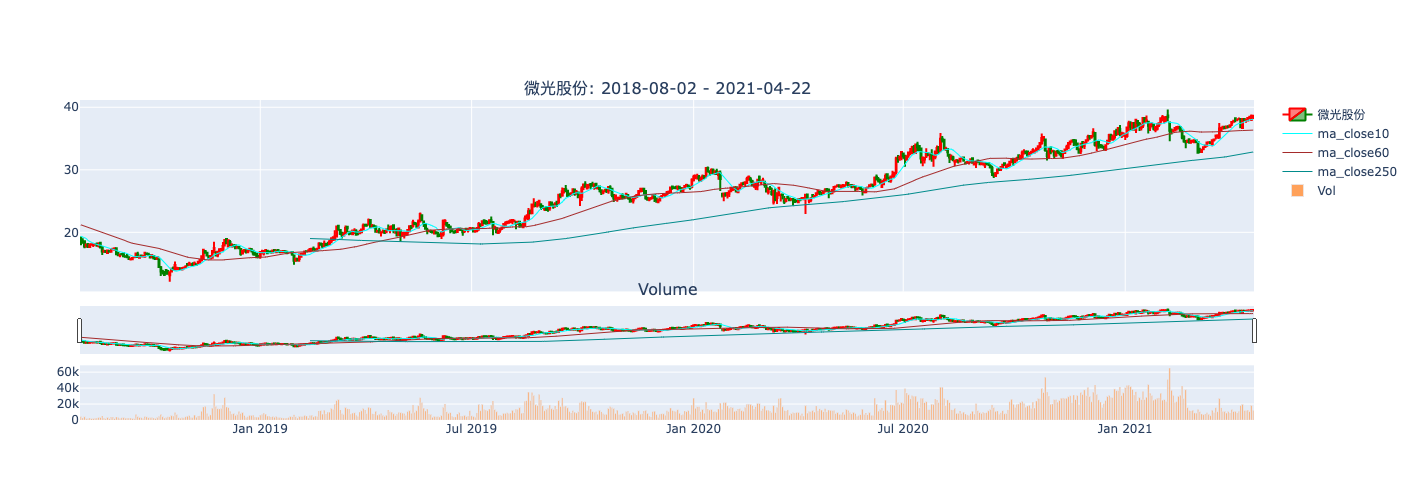

In [17]:
plot_k_plotly(df.loc['002801.SZ'], ma_spans=[10, 60, 250], height=500)

In [21]:
tdate = end_date
s=Strategy(name='xfe', stock_filter=StockFilter(tdate).not_st().zb())
s.add_condition('conseq_up_num', '=', val=1)
s.add_condition('conseq_up_num', '<', var='list_days')
s.add_condition('amount',  '<', val=2000000) # 15亿，unit: k
s.add_condition('circ_mv', '<', val=1000000) # 80亿，unit: w
s.add_condition('turnover_rate_f', '<', val=45)
s.add_condition('turnover_rate_f', '>=', val=7)
s.add_condition('high', '>', var='low', ratio=1.02) # 日内振幅大于 2% (非一字板）
s.add_condition('vol_ratio', '>', val=1.5)
s.add_condition('vol', '>', var='ma_vol_5', ratio=1.7)

tmp, _ = s.get_result(df=df, trade_date='2021-10-27')
check_performance(df=tmp)
# s.add_condition('next_open_pct', '>', val=0)

Searching 2021-10-27...


AttributeError: 'DataFrame' object has no attribute 'cvo'

In [ ]:
def (stra_name, tdate=None):
    stra = Strategy(name, StockFilter(tdate).not_st().zb())
    stra.rules = {}
    stra.add_condition('conseq_up_num', '>=', val=1)
    stra.add_condition('conseq_up_num', '<=', val=3)
    stra.add_condition('amount',  '<', val=2000000) # 15亿，unit: k
    stra.add_condition('circ_mv', '<', val=1000000) # 80亿，unit: w
    stra.add_condition('turnover_rate_f', '<', val=45)
    stra.add_condition('turnover_rate_f', '>=', val=7)
    stra.add_condition('high', '>', var='low', ratio=1.02) # 日内振幅大于 2% (非一字板）
    stra.add_condition('vol_ratio', '>', val=1.5)
    stra.add_condition('vol', '>', var='ma_vol_5', ratio=1.7)
    stra.add_condition('next_open_pct', '>', val=0)
    stra.add_condition('next_open_pct', '<', val=9)
    stra.add_condition('next_auc_amt_ratio', '>', val=0.04) # 竞价金额占昨日成交金额百分比 大于 4%
    stra.add_condition('next_auc_amt_ratio', '>', var='next_open_pct', ratio=0.01*3) # 竞价金额占昨日成交金额百分比 大于3倍 open_pct
    # stra.add_condition('next_auc_amt', '>', var='fd_amount', ratio=0.0002)
    stra.
    return stra


In [12]:
today_up.columns.to_list()

['open',
 'high',
 'low',
 'close',
 'pre_close',
 'change',
 'pct_chg',
 'vol',
 'amount',
 'adj_factor',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'total_mv',
 'circ_mv',
 'total_share',
 'float_share',
 'free_share',
 'last_factor',
 'norm_adj',
 'adj_vol',
 'pre_close_4',
 'pre_close_6',
 'pre_close_11',
 'pre_close_21',
 'pre_pct_chg',
 'pre3_pct_chg',
 'pre5_pct_chg',
 'pre10_pct_chg',
 'pre20_pct_chg',
 'next_close_1',
 'next_close_2',
 'next_close_3',
 'next_close_10',
 'next_close_20',
 'next_pct_chg',
 'next2_pct_chg',
 'next3_pct_chg',
 'next10_pct_chg',
 'next20_pct_chg',
 'max_pre60_close',
 'max_pre120_close',
 'avg_price',
 'open_pct',
 'next_open_pct',
 'ma_vol_5',
 'ma_vol_20',
 'vol_ratio',
 'vol_ratio_long',
 'vol_type',
 'pre_vol_type',
 'pre_trf',
 'buy_sm_vol',
 'buy_md_vol',
 'buy_lg_vol',
 'buy_elg_vol',
 'sell_sm_vol',
 'sell_md_vol',
 'sell_lg_vol',
 'sell_elg_vol',
 'buy_sm_amount',
 'buy_md_amount',
 'buy_lg_amount',
 'buy_elg

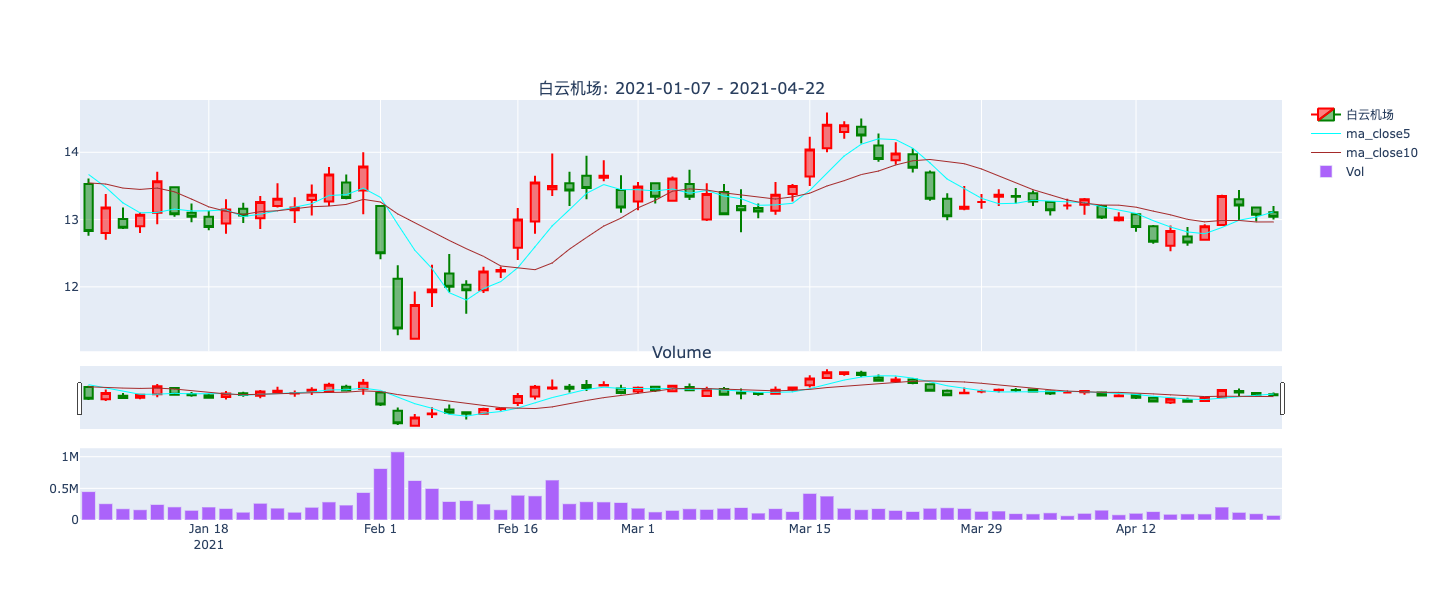

In [19]:
quick_k(code='600004.SH', df=df)

In [87]:
sumdf = pd.DataFrame(index=[tdate])
sumdf.loc[tdate,'wwfw']=1
sumdf

wwfw
2021-08-18   1.0

In [91]:
up_cols = {
    'up1_cnt': '首板个股数',
    'up2_cnt': '二板个股数',
    'up3_cnt': '三板个股数',
    'ups_cnt': '连板个股数',
    'up1_conseq_rate': '一进二胜率',
    'up2_conseq_rate': '二进三胜率',
    'ups_conseq_rate': '总连板胜率',
    'up1_drop_pct_mean': '一进二掉队均涨幅',
    'up2_drop_pct_mean': '二进三掉队均涨幅',
    'pre_up1_pct_mean': '昨首板个股今平均涨幅',
    'pre_up2_pct_mean': '昨二板个股今平均涨幅',
    'pre_ups_pct_mean': '昨连板个股均涨幅',
    'max_conseq': '最高连板数',
}

def update_al(df, tdate, verbose=False):
    pre_date = tdu.past_trade_days(end_date=tdate)[-2]
    print(f'Working {tdate}, yesterday is {pre_date}...')
    
    tdf = df.xs(slice(tdate, tdate), level='trade_date', drop_level=True)
    tup_df = tdf[(tdf.conseq_up_num>=1) & (tdf.list_days != tdf.conseq_up_num)]    
    pre_df = df.xs(pre_date, level='trade_date', drop_level=True)
    
    sumdf = pd.DataFrame(index=[tdate])
    sumdf.loc[tdate, 'up1_cnt'] = len(tup_df[tup_df.conseq_up_num == 1])
    sumdf.loc[tdate, 'up2_cnt'] = len(tup_df[tup_df.conseq_up_num == 2])
    sumdf.loc[tdate, 'up3_cnt'] = len(tup_df[tup_df.conseq_up_num == 3])
    sumdf.loc[tdate, 'ups_cnt'] = len(tup_df[tup_df.conseq_up_num > 1])
    
    for i in [1, 2]:
        sumdf.loc[tdate, f'up{i}_conseq_rate'] = round(
            100 * len(tup_df[tup_df.conseq_up_num == i+1]) / len(pre_df[(pre_df.conseq_up_num == i) & (pre_df.list_days != pre_df.conseq_up_num)]), 2)
    sumdf.loc[tdate, 'ups_conseq_rate'] = round(
            100 * len(tup_df[tup_df.conseq_up_num >= 2]) / len(pre_df[(pre_df.conseq_up_num == i) & (pre_df.list_days != pre_df.conseq_up_num)]), 2)

    pre_up1_tdate_drop_df = tdf[(tdf.conseq_up_num==0) & (tdf.pre_conseq_up_num==1)]
    sumdf.loc[tdate, 'up1_drop_pct_mean'] = round(pre_up1_tdate_drop_df.pct_chg.mean(), 2)
    pre_up2_tdate_drop_df = tdf[(tdf.conseq_up_num==0) & (tdf.pre_conseq_up_num==2)]
    sumdf.loc[tdate, 'up2_drop_pct_mean'] = round(pre_up2_tdate_drop_df.pct_chg.mean(), 2)

    sumdf.loc[tdate, 'pre_up1_pct_mean'] = round(tdf[tdf.pre_conseq_up_num == 1].pct_chg.mean(), 2)
    sumdf.loc[tdate, 'pre_up2_pct_mean'] = round(tdf[tdf.pre_conseq_up_num == 2].pct_chg.mean(), 2)
    sumdf.loc[tdate, 'pre_ups_pct_mean'] = round(tdf[tdf.pre_conseq_up_num > 1].pct_chg.mean(), 2)
    
    sumdf.loc[tdate, 'max_conseq'] = tup_df.conseq_up_num.max()

    return pre_df, tdf, sumdf
    # today 1st

tdate = '2021-08-18'
sumdf = pd.DataFrame()
for tmpd in tdu.future_trade_days(start_date=tdate)[:20]:
    print(f'=============== {tmpd} =======================')
    pre_df, tdf, tmpdf = update_al(df, tmpd)
    sumdf = sumdf.append(tmpdf)

sumdf

=============== 2021-08-19 =======================
Working 2021-08-19, yesterday is 2021-08-18...
=============== 2021-08-20 =======================
Working 2021-08-20, yesterday is 2021-08-19...
=============== 2021-08-23 =======================
Working 2021-08-23, yesterday is 2021-08-20...
=============== 2021-08-24 =======================
Working 2021-08-24, yesterday is 2021-08-23...
=============== 2021-08-25 =======================
Working 2021-08-25, yesterday is 2021-08-24...
=============== 2021-08-26 =======================
Working 2021-08-26, yesterday is 2021-08-25...
=============== 2021-08-27 =======================
Working 2021-08-27, yesterday is 2021-08-26...
=============== 2021-08-30 =======================
Working 2021-08-30, yesterday is 2021-08-27...
=============== 2021-08-31 =======================
Working 2021-08-31, yesterday is 2021-08-30...
=============== 2021-09-01 =======================
Working 2021-09-01, yesterday is 2021-08-31...
=============== 2021

up1_cnt  up2_cnt  up3_cnt  ups_cnt  up1_conseq_rate  \
2021-08-19     42.0     10.0      2.0     14.0            13.70   
2021-08-20     48.0      5.0      3.0     10.0            11.90   
2021-08-23    109.0     18.0      4.0     24.0            37.50   
2021-08-24     59.0     14.0      6.0     24.0            12.84   
2021-08-25     73.0      8.0      6.0     20.0            13.56   
2021-08-26     59.0      8.0      1.0     16.0            10.96   
2021-08-27     78.0     15.0      1.0     20.0            25.42   
2021-08-30     74.0     17.0      8.0     30.0            21.79   
2021-08-31     79.0     17.0      5.0     28.0            22.97   
2021-09-01     62.0     14.0      3.0     21.0            17.72   
2021-09-02    113.0      6.0      5.0     13.0             9.68   
2021-09-03     46.0     11.0      2.0     18.0             9.73   
2021-09-06     77.0     13.0      5.0     19.0            28.26   
2021-09-07    100.0     15.0      2.0     18.0            19.48   
2021-09-08     78.0     15.0      6.0     23.0            15.00   
2021-09-09     74.0      8.0      5.0     17.0            10.26   
2021-09-10     42.0      8.0      4.0     18.0            10.81   
2021-09-13     83.0     11.0      2.0     18.0            26.19   
2021-09-14     53.0     12.0      4.0     21.0            14.46   
2021-09-15     89.0      3.0      8.0     14.0             5.66   

            up2_conseq_rate  ups_conseq_rate  up1_drop_pct_mean  \
2021-08-19            50.00           350.00              -1.27   
2021-08-20            30.00           100.00               0.26   
2021-08-23            80.00           480.00               3.54   
2021-08-24            33.33           133.33               1.52   
2021-08-25            42.86           142.86               0.34   
2021-08-26            12.50           200.00               0.12   
2021-08-27            12.50           250.00               0.29   
2021-08-30            53.33           200.00               1.78   
2021-08-31            29.41           164.71               1.72   
2021-09-01            17.65           123.53              -0.63   
2021-09-02            35.71            92.86               1.17   
2021-09-03            33.33           300.00               0.29   
2021-09-06            45.45           172.73               1.09   
2021-09-07            15.38           138.46               0.72   
2021-09-08            40.00           153.33               1.14   
2021-09-09            33.33           113.33              -0.79   
2021-09-10            50.00           225.00              -1.85   
2021-09-13            25.00           225.00               0.80   
2021-09-14            36.36           190.91               0.33   
2021-09-15            66.67           116.67               0.57   

            up2_drop_pct_mean  pre_up1_pct_mean  pre_up2_pct_mean  \
2021-08-19               0.60             -0.08              5.31   
2021-08-20               0.47              0.95              2.82   
2021-08-23               4.43              5.76              5.86   
2021-08-24               0.26              2.57              3.22   
2021-08-25               2.46              1.39              4.62   
2021-08-26               0.52              1.07              1.09   
2021-08-27               0.55              2.07              1.10   
2021-08-30               1.42              3.34              4.69   
2021-08-31               3.46              3.10              4.80   
2021-09-01              -2.79              1.13             -1.12   
2021-09-02               2.88              1.78              4.36   
2021-09-03              -0.84              1.10              1.13   
2021-09-06              -0.15              3.50              4.00   
2021-09-07               0.84              2.06              2.25   
2021-09-08              -0.53              2.47              3.69   
2021-09-09               0.56              0.25              3.05   
2021-09-10             

In [94]:
plot_mline(df=sumdf, legend_labels=[
    'up1_cnt', 'up2_cnt', 'ups_cnt', 
    'up1_conseq_rate', 'up2_conseq_rate',
    'pre_up1_pct_mean', 'pre_up2_pct_mean', 'pre_ups_pct_mean'], title='连板趋势', y_label='xx')

In [90]:
tmpdf

up1_cnt  up2_cnt  up3_cnt  ups_cnt  up1_conseq_rate  \
2021-09-15      NaN      NaN      NaN      NaN             5.66   

            up2_conseq_rate  ups_conseq_rate  up1_drop_pct_mean  \
2021-09-15            66.67           116.67               0.57   

            up2_drop_pct_mean  pre_up1_pct_mean  pre_up2_pct_mean  \
2021-09-15               -1.3              0.91              5.38   

            pre_ups_pct_mean  max_conseq  
2021-09-15              4.49         8.0

In [83]:
def update_al(df, tdate, verbose=False):
    sumdf = pd.DataFrame(index=[tdate])
    
    # pre_date = pdl.parse(tdate).add(days=-1).to_date_string()
    pre_date = tdu.past_trade_days(end_date=tdate)[-2]
    pre_df = df.xs(pre_date, level='trade_date', drop_level=True)
    
    print(f'Working {tdate}, yesterday is {pre_date}...')
    tdf = df.xs(slice(tdate, tdate), level='trade_date', drop_level=True)
    
    pre_up_df = pre_df[(pre_df.conseq_up_num>=1) & (pre_df.list_days != pre_df.conseq_up_num)]
    pre_ups_df = pre_df[(pre_df.conseq_up_num>1) & (pre_df.list_days != pre_df.conseq_up_num)]
    
    pre_up1_df = pre_df[(pre_df.conseq_up_num==1) & (pre_df.list_days != pre_df.conseq_up_num)]
    # pre_up1_stks = pre_up1_df.index.to_list()
    pre_up1_stks = intersection(tdf.index.to_list(), pre_up1_df.index.to_list())
    if verbose:
        print(', '.join(pre_up1_stks))
    pre_up1_tdate_pct_chg_avg  = round(tdf.loc[pre_up1_stks].pct_chg.mean(), 2)
    pre_up1_tdate_open_chg_avg = round(tdf.loc[pre_up1_stks].open_pct.mean(), 2)
    print(f'昨日首板今日开盘涨幅：{pre_up1_tdate_open_chg_avg}%，平均涨幅：{pre_up1_tdate_pct_chg_avg}%')

    tdate_up2_df = tdf[(tdf.conseq_up_num==2) & (tdf.list_days != tdf.conseq_up_num)]
    print(f'昨日首板今日晋级率: {round(len(tdate_up2_df)/len(pre_up1_df)*100, 1)}% ({len(tdate_up2_df)}/{len(pre_up1_df)})，开盘平均涨幅：{round(tdate_up2_df.open_pct.mean(),2)}%')
    
    pre_up1_tdate_drop_df = tdf[(tdf.conseq_up_num==0) & (tdf.pre_conseq_up_num==1)]
    print(f'昨日首板今日掉队股开盘涨幅：{round(pre_up1_tdate_drop_df.open_pct.mean(),2)}%，平均涨幅：{round(pre_up1_tdate_drop_df.pct_chg.mean(),2)}%')
   
    pre_up2_df = pre_df[(pre_df.conseq_up_num==2) & (pre_df.list_days != pre_df.conseq_up_num)]
    pre_up2_tdate_df = tdf.loc[pre_up2_df.index.to_list()]
    tdate_up3_df = tdf[(tdf.conseq_up_num==3) & (tdf.list_days != tdf.conseq_up_num)]
    # pre_up2_stks = 
    print(f'昨日二板今日晋级率: {round(len(tdate_up3_df)/len(pre_up2_df)*100, 1)}% ({len(tdate_up3_df)}/{len(pre_up2_df)})，开盘平均涨幅：{round(tdate_up3_df.open_pct.mean(),2)}%')
    
    pre_up2_tdate_drop_df = tdf[(tdf.conseq_up_num==0) & (tdf.pre_conseq_up_num==2)]
    print(f'昨日二板今日掉队股开盘涨幅：{round(pre_up2_tdate_drop_df.open_pct.mean(),2)}%，平均涨幅：{round(pre_up2_tdate_drop_df.pct_chg.mean(),2)}%')
   

    return pre_df, tdf, sumdf
    # today 1st

tdate = '2021-08-18'
for tmpd in tdu.future_trade_days(start_date=tdate)[:20]:
    print(f'=============== {tmpd} =======================')
    pre_df, tdf = update_al(df, tmpd)

=============== 2021-08-19 =======================
Working 2021-08-19, yesterday is 2021-08-18...
昨日首板今日开盘涨幅：1.61%，平均涨幅：-0.05%
昨日首板今日晋级率: 13.7% (10/73)，开盘平均涨幅：4.05%
昨日首板今日掉队股开盘涨幅：1.23%，平均涨幅：-1.27%
昨日二板今日晋级率: 50.0% (2/4)，开盘平均涨幅：4.95%
昨日二板今日掉队股开盘涨幅：5.19%，平均涨幅：0.6%
=============== 2021-08-20 =======================
Working 2021-08-20, yesterday is 2021-08-19...
昨日首板今日开盘涨幅：0.63%，平均涨幅：0.95%
昨日首板今日晋级率: 11.9% (5/42)，开盘平均涨幅：1.68%
昨日首板今日掉队股开盘涨幅：0.49%，平均涨幅：0.26%
昨日二板今日晋级率: 30.0% (3/10)，开盘平均涨幅：2.12%
昨日二板今日掉队股开盘涨幅：-0.09%，平均涨幅：0.47%
=============== 2021-08-23 =======================
Working 2021-08-23, yesterday is 2021-08-20...
昨日首板今日开盘涨幅：3.14%，平均涨幅：5.76%
昨日首板今日晋级率: 37.5% (18/48)，开盘平均涨幅：5.15%
昨日首板今日掉队股开盘涨幅：1.94%，平均涨幅：3.54%
昨日二板今日晋级率: 80.0% (4/5)，开盘平均涨幅：4.27%
昨日二板今日掉队股开盘涨幅：2.06%，平均涨幅：4.43%
=============== 2021-08-24 =======================
Working 2021-08-24, yesterday is 2021-08-23...
昨日首板今日开盘涨幅：2.64%，平均涨幅：2.57%
昨日首板今日晋级率: 12.8% (14/109)，开盘平均涨幅：5.25%
昨日首板今日掉队股开盘涨幅：2.26%，平均涨幅：1.52%
昨日二板今日晋级率: 33.3%

In [82]:
pre_df, tdf = update_al(df, '2021-08-30', verbose=True)

Working 2021-08-30, yesterday is 2021-08-27...
000032.SZ, 000153.SZ, 000422.SZ, 000546.SZ, 000635.SZ, 000683.SZ, 000815.SZ, 000820.SZ, 000822.SZ, 000833.SZ, 000971.SZ, 002009.SZ, 002021.SZ, 002048.SZ, 002057.SZ, 002113.SZ, 002125.SZ, 002132.SZ, 002135.SZ, 002218.SZ, 002240.SZ, 002241.SZ, 002268.SZ, 002274.SZ, 002312.SZ, 002323.SZ, 002340.SZ, 002411.SZ, 002490.SZ, 002497.SZ, 002504.SZ, 002539.SZ, 002592.SZ, 002619.SZ, 002640.SZ, 002681.SZ, 002759.SZ, 002895.SZ, 002897.SZ, 300262.SZ, 300488.SZ, 300490.SZ, 300505.SZ, 600007.SH, 600091.SH, 600096.SH, 600112.SH, 600126.SH, 600139.SH, 600146.SH, 600366.SH, 600367.SH, 600403.SH, 600408.SH, 600470.SH, 600518.SH, 600589.SH, 600602.SH, 600711.SH, 600739.SH, 600777.SH, 600804.SH, 600960.SH, 601117.SH, 601127.SH, 601388.SH, 601678.SH, 603033.SH, 603040.SH, 603069.SH, 603077.SH, 603286.SH, 603338.SH, 603396.SH, 603662.SH, 603718.SH, 603730.SH, 603897.SH


KeyError: "['600112.SH'] not in index"

In [ ]:
    
    # yesterday 1st
    
    
    # today 2nd
    today_df.loc[:, 'c_v_o'] = today_df.pct_chg - today_df.open_pct
    if backtest:
        back_test_cols = ['next_limit', 'next_pct_chg']
    else:
        back_test_cols = []
    raw_today_up = today_df[today_df.limit == 'U']
    return tdf

In [34]:
upstop_analyze(tdate=end_date, backtest=True, df=df, show_detail=True)

Showing upstop stocks on 2021-10-29...


KeyError: "['next_limit'] not in index"

In [35]:
df.loc['600004.SH'][[
    'close',
    'ma_close_5',
    'ma_close_10',
    'ma_close_30',
    'ma_close_60',
    'ma_close_120',
    'ma_close_250',
    'turnover_rate_f',
    'limit',
    'vol',
    'conseq_up_num',
    'amount',
    'pct_chg'
]].tail(50).head(5)

close  ma_close_5  ma_close_10  ma_close_30  ma_close_60  \
trade_date                                                             
2021-08-12   8.70       8.638        8.628     9.676333    10.608833   
2021-08-13   8.74       8.712        8.631     9.602667    10.555167   
2021-08-16   9.08       8.798        8.677     9.545000    10.508000   
2021-08-17   8.96       8.856        8.704     9.482000    10.458167   
2021-08-18   9.12       8.920        8.759     9.424333    10.408833   

            ma_close_120  ma_close_250  turnover_rate_f limit        vol  \
trade_date                                                                 
2021-08-12     11.785167      12.87308           1.4652  None  148415.88   
2021-08-13     11.745583      12.85216           0.8513  None   86233.82   
2021-08-16     11.709250      12.83284           2.5849  None  261846.89   
2021-08-17     11.672500      12.81244           4.1099  None  416320.06   
2021-08-18     11.636750      12.79172           1.8154  None  183892.77   

            conseq_up_num      amount  pct_chg  
trade_date                                      
2021-08-12              0  130313.055  -1.1312  
2021-08-13              0   75319.516   0.4598  
2021-08-16              0  233946.420   3.8902  
2021-08-17              0  382284.800  -1.3216  
2021-08-18              0  167254.080   1.7857

In [13]:


df.loc[:, 'bar_type'] = df.apply(f_calc_yinyang, axis=1)
df.loc[:, 'pre_bar_type'] = df.groupby('ts_code').bar_type.shift(1)
df.loc[:, 'pre2_bar_type'] = df.groupby('ts_code').bar_type.shift(2)
df.loc[:, 'pre2_pct_chg'] = df.groupby('ts_code').pct_chg.shift(2)
df.loc[:, 'pre2_conseq_up_num'] = df.groupby('ts_code').conseq_up_num.shift(2)
df.loc[:, 'pre2_close'] = df.groupby('ts_code').close.shift(2)

In [8]:
', '.join(df.columns.to_list())

'open, high, low, close, pre_close, change, pct_chg, vol, amount, adj_factor, turnover_rate, turnover_rate_f, volume_ratio, pe, pe_ttm, total_mv, circ_mv, total_share, float_share, free_share, last_factor, norm_adj, adj_vol, pre_close_4, pre_close_6, pre_close_11, pre_close_21, pre_pct_chg, pre3_pct_chg, pre5_pct_chg, pre10_pct_chg, pre20_pct_chg, next_close_1, next_close_2, next_close_3, next_close_10, next_close_20, next_pct_chg, next2_pct_chg, next3_pct_chg, next10_pct_chg, next20_pct_chg, max_pre60_close, max_pre120_close, avg_price, open_pct, next_open_pct, ma_vol_5, ma_vol_20, vol_ratio, vol_ratio_long, vol_type, pre_vol_type, pre_trf, buy_sm_vol, buy_md_vol, buy_lg_vol, buy_elg_vol, sell_sm_vol, sell_md_vol, sell_lg_vol, sell_elg_vol, buy_sm_amount, buy_md_amount, buy_lg_amount, buy_elg_amount, sell_sm_amount, sell_md_amount, sell_lg_amount, sell_elg_amount, net_mf_vol, net_mf_amount, amp, fc_ratio, fl_ratio, fd_amount, first_time, last_time, open_times, strth, limit, name, list

In [38]:
# 近期大热，2 阴线洗盘
t1 = Strategy('double_yin', StockFilter(end_date).not_st().zb())
# t1.add_condition('bar_type', '=', 'yin')
# t1.add_condition('pre_bar_type', '=', 'yin')
# t1.add_condition('close', '>', var='pre2_close')
# t1.add_condition('pre_close', '>', var='pre2_close')
# t1.add_condition('pre2_conseq_up_num', '=', 2)
# t1.add_condition('pre2_conseq_up_num', '<=', 2)
# t1.add_condition('vol_ratio', '>=', 1)
# t1.add_condition('vol_ratio', '<=', 1.3)
t1.add_condition('conseq_up_num', '=', 2)

In [39]:
res, keys = t1.get_result(df)
res_dict = sum_diff(df, res)
pd.DataFrame(data=res_dict)

next_open_pct_mean  next_pct_chg_mean  next2_pct_chg_mean  \
Original           -0.062744           0.065268            0.132432   
Filtered            3.180017           2.344255            2.700609   

          next_up_rate  next2_up_rate  
Original      0.474438       0.473310  
Filtered      0.605848       0.543435

In [33]:
res1 = res.sort_index(level='trade_date').tail(20)[['name', 'vol_ratio', 'pct_chg', 'bar_type', 'pre_pct_chg', 'pre_bar_type', 'pre2_pct_chg', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']]
style_df(res1)

In [40]:
# T 字板
t1 = Strategy('t1', StockFilter(end_date).not_st())
t1.add_condition('up_type', '=', 'T')
t1.add_condition('conseq_up_num', '>', 1)
t1.add_condition('', '')
# t1.add_condition('next_open_pct', '<', 5)
# t1.add_condition('next_open_pct', '>', 0)
t1.add_condition('close', '<', var='ma_close_250', ratio=1.5)
res, keys = t1.get_result(df)

In [16]:
def back_test(strat, df):
    res, keys = t1.get_result(df)
    res_dict = sum_diff(df, res)
    display(pd.DataFrame(data=res_dict))
    res1 = res.sort_index(level='trade_date').tail(20)[['name', 'vol_ratio', 'close', 'ma_close_10', 'ma_close_250', 'turnover_rate_f', 'pct_chg', 'pre_pct_chg', 'pre_bar_type', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']]
    display(style_df(res1))
    return res

In [59]:
res1 = res.sort_index(level='trade_date').tail(30)[['name', 'vol_ratio', 'close', 'ma_close_10', 'ma_close_250', 'turnover_rate_f', 'pct_chg', 'pre_pct_chg', 'pre_bar_type', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']]
style_df(res1)

In [28]:
# 300大涨次日大跌
t1 = Strategy('300up&down', StockFilter(end_date).not_st().cyb())
t1.add_condition('open', '<', var='pre_close', ratio=0.98)
t1.add_condition('open', '>', var='close', ratio=1.05)
t1.add_condition('high', '<', var='pre_close')
t1.add_condition('pre_pct_chg', '>', 14)
t1.add_condition('pct_chg', '<', -6)
t1.add_condition('next_open_pct', '>', 0)
t1.add_condition('next_open_pct', '<', 3)
# test
res, keys = t1.get_result(df)
res_dict = sum_diff(df, res)
pd.DataFrame(data=res_dict)

next_open_pct_mean  next_pct_chg_mean  next2_pct_chg_mean  \
Original           -0.062744           0.065268            0.132432   
Filtered            0.930205           3.153371            3.944518   

          next_up_rate  next2_up_rate  
Original      0.474438        0.47331  
Filtered      0.750000        0.60000

In [29]:
res1 = res.sort_index(level='trade_date').tail(30)[['name'] + keys + ['vol_ratio', 'turnover_rate_f', 'next_pct_chg', 'next2_pct_chg']]
style_df(res1)

In [3]:
ups = df[df.conseq_up_num>=1].xs(end_date, level='trade_date').sort_values('conseq_up_num', ascending=False)

In [31]:
up_hist = df[df.conseq_up_num>=1]

In [34]:

up_hist[up_hist.turnover_rate_f<60].next_pct_chg.mean()

1.9833628029882502

In [4]:
from utils.strategy import Strategy

In [5]:
stra = Strategy('test', df)

In [28]:
stra.rules={}

In [29]:
stra.add_condition('pre_conseq_up_num', '=', val=2)

In [30]:
stra.add_condition('pre_trf', '<', val=30)
stra.add_condition('pre_trf', '>', val=5)

In [9]:
stra.add_condition('open_pct', '>', val=2)
stra.add_condition('open_pct', '<', val=3)

In [31]:
stra.add_condition('list_days', '>', var='conseq_up_num')

In [32]:
stra.rules

{'pre_conseq_up_num': [{'op': '=', 'val': 2}],
 'pre_trf': [{'op': '<', 'val': 30}, {'op': '>', 'val': 5}],
 'list_days': [{'op': '>', 'var': 'conseq_up_num'}]}

全体平均涨幅：2.14%，非一字板平均涨幅：2.05%
Y类板占比：2.0%，平均涨幅：6.06%
T类板占比：10.0%，平均涨幅：1.96%
H类板占比：2.0%，平均涨幅：0.44%
W类板占比：16.0%，平均涨幅：2.51%
L类板占比：9.0%，平均涨幅：2.56%
O类板占比：62.0%，平均涨幅：1.93%
M类板占比：0.0%，平均涨幅：nan%
跌停票占比：4.0%，涨停票占比：29.0%


open    high     low   close  pre_close  change  \
ts_code   trade_date                                                      
000004.SZ 2021-06-11   23.98   23.98   23.68   23.98      21.80    2.18   
          2021-07-14   22.00   24.90   21.56   22.80      22.64    0.16   
000007.SZ 2021-02-22    3.14    3.36    3.14    3.36       3.05    0.31   
          2021-03-10    4.39    4.82    4.07    4.37       4.38   -0.01   
          2021-06-24    4.04    4.13    3.92    3.95       3.97   -0.02   
...                      ...     ...     ...     ...        ...     ...   
688316.SH 2021-06-02   90.00  106.19   88.49   95.32      88.49    6.83   
688357.SH 2021-10-18  185.53  192.88  181.00  187.79     187.86   -0.07   
688663.SH 2021-08-02   39.00   42.50   36.79   37.70      36.00    1.70   
688699.SH 2021-04-27  137.86  138.44  116.09  124.38     136.36  -12.04   
          2021-07-02  390.40  410.86  377.00  384.75     342.38   42.37   

                      pct_chg        vol       amount  adj_factor  \
ts_code   trade_date                                                
000004.SZ 2021-06-11  10.0000   56161.45   134672.950       4.064   
          2021-07-14   0.7067  262125.33   595037.600       4.064   
000007.SZ 2021-02-22  10.1639  183718.62    59913.582       8.284   
          2021-03-10  -0.2283  981915.70   445540.840       8.284   
          2021-06-24  -0.5038  144224.80    57619.656       8.284   
...                       ...        ...          ...         ...   
688316.SH 2021-06-02   7.7184   38686.67   388063.440       1.000   
688357.SH 2021-10-18  -0.0373   20708.57   386964.380       1.020   
688663.SH 2021-08-02   4.7222  164926.80   649362.060       1.014   
688699.SH 2021-04-27  -8.7858   53321.60   669799.750       1.000   
          2021-07-02  12.3751   63901.97  2518739.000       1.005   

                      turnover_rate  turnover_rate_f  volume_ratio        pe  \
ts_code   trade_date                                                           
000004.SZ 2021-06-11         4.8783           6.1548          0.62   61.2468   
          2021-07-14        22.7686          28.7268          3.09   58.2330   
000007.SZ 2021-02-22         5.9466           8.5120          0.90   52.2295   
          2021-03-10        31.7826          45.4940          1.58   67.9294   
          2021-06-24         4.6683           5.6001          2.39       NaN   
...                             ...              ...           ...       ...   
688316.SH 2021-06-02        35.7049          35.7049          3.67       NaN   
688357.SH 2021-10-18         7.8839           8.9609          2.46   85.2474   
688663.SH 2021-08-02        54.7069          54.7069          2.72   49.4393   
688699.SH 2021-04-27        31.5246          31.5246          3.04   85.0761   
          2021-07-02        36.1797          36.1797          3.58  261.8642   

                        pe_ttm    total_mv    circ_mv  total_share  \
ts_code   trade_date                                                 
000004.SZ 2021-06-11   60.7922   395796.20  276071.25   16505.2620   
          2021-07-14   57.8007   376320.00  262486.40   16505.2620   
000007.SZ 2021-02-22       NaN   116406.54  103806.54   34644.8050   
          2021-03-10       NaN   151397.80  135010.30   34644.8050   
          2021-06-24       NaN   136846.98  122034.48   34644.8050   
...                        ...         ...        ...          ...   
688316.SH 2021-06-02       NaN   452409.44  103280.42    4746.2173   
688357.SH 2021-10-18   60.8519  1085801.80  493268.00    5782.0000   
688663.SH 2021-08-02   44.3147   527611.50  113655.49   13995.0000   
688699.SH 2021-04-27   57.5616   929600.00  211428.86    7436.8000   
          2021-07-02  177.1747  2861308.80  679560.80    7436.8000   

                      float_share  free_share  last_factor  norm_adj  \
ts_code   trade_date                                                   
000004.SZ 2021-06-11   11512.5620   9124.7560        4

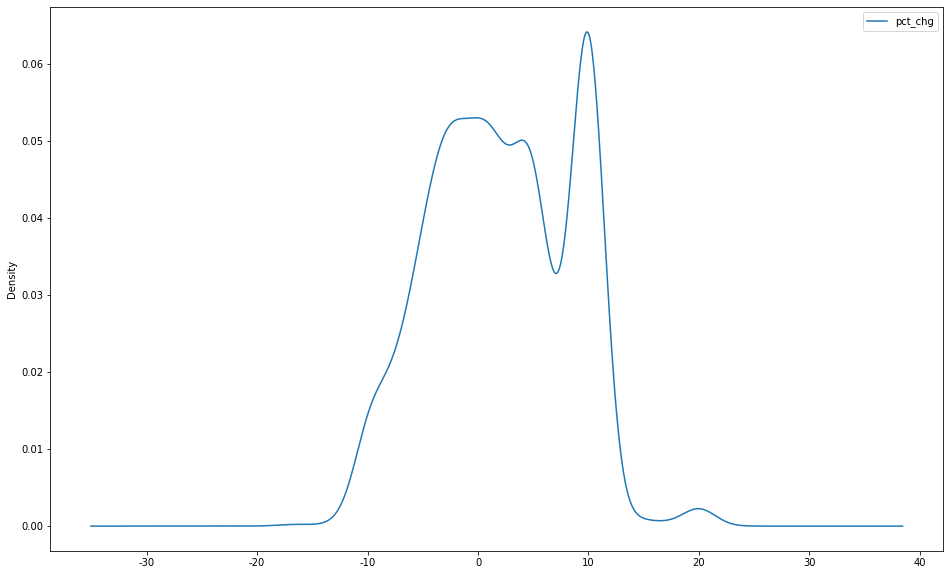

In [33]:
res, keys = stra.get_result()
show_upstop_stat(res)

In [35]:
res.open_pct.mean()

2.7348363371340088

In [3]:
# plot stuff

from utils.env_plt import *

In [26]:
sf = StockFilter(end_date=end_date)

In [50]:
df1 = sf.not_new().not_st().cyb().filter(df)
df1

open   high    low  close  pre_close  change  pct_chg  \
ts_code   trade_date                                                           
300001.SZ 2020-09-09  19.96  20.06  19.28  19.31      20.09   -0.78  -3.8748   
          2020-09-10  19.46  19.60  17.77  17.98      19.31   -1.34  -6.9251   
          2020-09-11  17.86  18.48  17.29  18.41      17.98    0.43   2.3876   
          2020-09-14  18.57  18.81  18.22  18.62      18.41    0.21   1.1388   
          2020-09-15  18.70  18.70  18.23  18.39      18.62   -0.23  -1.2332   
...                     ...    ...    ...    ...        ...     ...      ...   
300999.SZ 2021-09-17  67.85  69.29  66.83  68.30      68.21    0.09   0.1319   
          2021-09-22  67.13  67.99  66.82  66.98      68.30   -1.32  -1.9327   
          2021-09-23  66.95  68.10  66.90  67.17      66.98    0.19   0.2837   
          2021-09-24  67.30  71.72  67.18  69.75      67.17    2.58   3.8410   
          2021-09-27  69.10  75.60  69.10  73.25      69.75    3.50   5.0179   

                            vol      amount  adj_factor  turnover_rate  \
ts_code   trade_date                                                     
300001.SZ 2020-09-09  135646.08   266709.00       6.921         1.4358   
          2020-09-10  240768.03   443505.00       6.921         2.5486   
          2020-09-11  151875.53   272332.94       6.921         1.6076   
          2020-09-14   86494.82   160439.89       6.921         0.9156   
          2020-09-15   72857.69   134183.72       6.921         0.7712   
...                         ...         ...         ...            ...   
300999.SZ 2021-09-17  110430.44   751482.75       1.001         2.7910   
          2021-09-22   63016.03   422795.70       1.001         1.5927   
          2021-09-23   62266.99   418978.30       1.001         1.5737   
          2021-09-24  209837.11  1467635.50       1.001         5.3035   
          2021-09-27  282900.94  2067810.80       1.001         7.1501   

                      turnover_rate_f  volume_ratio       pe   pe_ttm  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09           2.5463          0.75  71.4367  97.4154   
          2020-09-10           4.5197          1.65  66.4897  90.6693   
          2020-09-11           2.8510          0.99  68.0772  92.8341   
          2020-09-14           1.6237          0.57  68.8525  93.8913   
          2020-09-15           1.3677          0.50  68.0033  92.7334   
...                               ...           ...      ...      ...   
300999.SZ 2021-09-17           2.7910          1.12  61.7068  62.0937   
          2021-09-22           1.5927          0.61  60.5142  60.8936   
          2021-09-23           1.5737          0.63  60.6859  61.0663   
          2021-09-24           5.3035          2.24  63.0168  63.4119   
          2021-09-27           7.1501          2.43  66.1790  66.5939   

                        total_mv    circ_mv  total_share  float_share  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09   1930298.1  1828039.9     99757.01     94472.34   
          2020-09-10   1796623.8  1701447.0     99757.01     94472.34   
          2020-09-11   1839519.2  1742070.0     99757.01     94472.34   
          2020-09-14   1860468.2  1761909.2     99757.01     94472.34   
          2020-09-15   1837524.1  1740180.6     99757.01     94472.34   
...                          ...        ...          ...          ...   
300999.SZ 2021-09-17  37029472.0  2702361.2    542159.10     39566.05   
          2021-09-22  36313820.0  2650134.0    542159.10     39566.05   
          2021-09-23  36416832.0  2657651.8    542159.10     39566.05   
          2021-09-24  37815600.0  2759732.0    542159.10     39566.05   
          2021-09-27  39713160.0  2898213.2    542159.10     39566.05   

                      free_share  last_factor  pre_close_4  pre_close_6  \
ts_code   trade_date                        

In [51]:
df2 = df1.loc['300502.SZ']
df2.name

trade_date
2020-09-09    新易盛
2020-09-10    新易盛
2020-09-11    新易盛
2020-09-14    新易盛
2020-09-15    新易盛
             ... 
2021-09-17    新易盛
2021-09-22    新易盛
2021-09-23    新易盛
2021-09-24    新易盛
2021-09-27    新易盛
Name: name, Length: 255, dtype: object

In [54]:
df2['avg_price'] = cn_round_price(df2.amount * 10 / df2.vol)
df2.avg_price

trade_date
2020-09-09    60.24
2020-09-10    58.75
2020-09-11    58.46
2020-09-14    61.21
2020-09-15    62.34
              ...  
2021-09-17    32.77
2021-09-22    32.55
2021-09-23    33.46
2021-09-24    32.86
2021-09-27    33.99
Name: avg_price, Length: 255, dtype: float64

In [80]:
df1.loc[:,f'adj_vol'] = (df1.vol/df1.norm_adj).apply(lambda p: cn_round_price(p))

In [49]:
df.loc[:, 'norm_adj'] =  df.adj_factor / df.last_factor

In [107]:
def gen_vwap(df, spans=None):
    if not spans:
        spans = [5, 10]
    for span in spans:
        vol_in_span = df.groupby(level='ts_code').adj_vol.apply(lambda x: x.rolling(window=span).sum())
        amt_in_span = df.groupby(level='ts_code').amount.apply(lambda x: x.rolling(window=span).sum())
        
        df.loc[:, f'vwap_{span}'] = (amt_in_span/vol_in_span).apply(lambda p: cn_round_price(p*10))
#         x = (amt_in_span/vol_in_span).apply(lambda p: cn_round_price(p*10))
#     return vol_in_span, amt_in_span, x
    return df
df2 = gen_vwap(df1, spans=[5, 10, 30])

In [109]:
from utils.stock_utils import *

open   high    low  close  pre_close  change  pct_chg  \
ts_code   trade_date                                                           
300001.SZ 2020-09-09  19.96  20.06  19.28  19.31      20.09   -0.78  -3.8748   
          2020-09-10  19.46  19.60  17.77  17.98      19.31   -1.34  -6.9251   
          2020-09-11  17.86  18.48  17.29  18.41      17.98    0.43   2.3876   
          2020-09-14  18.57  18.81  18.22  18.62      18.41    0.21   1.1388   
          2020-09-15  18.70  18.70  18.23  18.39      18.62   -0.23  -1.2332   
...                     ...    ...    ...    ...        ...     ...      ...   
300999.SZ 2021-09-17  67.85  69.29  66.83  68.30      68.21    0.09   0.1319   
          2021-09-22  67.13  67.99  66.82  66.98      68.30   -1.32  -1.9327   
          2021-09-23  66.95  68.10  66.90  67.17      66.98    0.19   0.2837   
          2021-09-24  67.30  71.72  67.18  69.75      67.17    2.58   3.8410   
          2021-09-27  69.10  75.60  69.10  73.25      69.75    3.50   5.0179   

                            vol      amount  adj_factor  turnover_rate  \
ts_code   trade_date                                                     
300001.SZ 2020-09-09  135646.08   266709.00       6.921         1.4358   
          2020-09-10  240768.03   443505.00       6.921         2.5486   
          2020-09-11  151875.53   272332.94       6.921         1.6076   
          2020-09-14   86494.82   160439.89       6.921         0.9156   
          2020-09-15   72857.69   134183.72       6.921         0.7712   
...                         ...         ...         ...            ...   
300999.SZ 2021-09-17  110430.44   751482.75       1.001         2.7910   
          2021-09-22   63016.03   422795.70       1.001         1.5927   
          2021-09-23   62266.99   418978.30       1.001         1.5737   
          2021-09-24  209837.11  1467635.50       1.001         5.3035   
          2021-09-27  282900.94  2067810.80       1.001         7.1501   

                      turnover_rate_f  volume_ratio       pe   pe_ttm  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09           2.5463          0.75  71.4367  97.4154   
          2020-09-10           4.5197          1.65  66.4897  90.6693   
          2020-09-11           2.8510          0.99  68.0772  92.8341   
          2020-09-14           1.6237          0.57  68.8525  93.8913   
          2020-09-15           1.3677          0.50  68.0033  92.7334   
...                               ...           ...      ...      ...   
300999.SZ 2021-09-17           2.7910          1.12  61.7068  62.0937   
          2021-09-22           1.5927          0.61  60.5142  60.8936   
          2021-09-23           1.5737          0.63  60.6859  61.0663   
          2021-09-24           5.3035          2.24  63.0168  63.4119   
          2021-09-27           7.1501          2.43  66.1790  66.5939   

                        total_mv    circ_mv  total_share  float_share  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09   1930298.1  1828039.9     99757.01     94472.34   
          2020-09-10   1796623.8  1701447.0     99757.01     94472.34   
          2020-09-11   1839519.2  1742070.0     99757.01     94472.34   
          2020-09-14   1860468.2  1761909.2     99757.01     94472.34   
          2020-09-15   1837524.1  1740180.6     99757.01     94472.34   
...                          ...        ...          ...          ...   
300999.SZ 2021-09-17  37029472.0  2702361.2    542159.10     39566.05   
          2021-09-22  36313820.0  2650134.0    542159.10     39566.05   
          2021-09-23  36416832.0  2657651.8    542159.10     39566.05   
          2021-09-24  37815600.0  2759732.0    542159.10     39566.05   
          2021-09-27  39713160.0  2898213.2    542159.10     39566.05   

                      free_share  last_factor  pre_close_4  pre_close_6  \
ts_code   trade_date                        

In [111]:
df2['2021-05-01':'2021-09-27'][['adj_factor', 'close', 'vwap_5', 'vwap_30']]

Empty DataFrame
Columns: [adj_factor, close, vwap_5, vwap_30]
Index: []

In [105]:
df1.groupby(level='ts_code').pct_chg.apply(lambda x: x.rolling(window=5).sum())

ts_code    trade_date
300001.SZ  2020-09-09       NaN
           2020-09-10       NaN
           2020-09-11       NaN
           2020-09-14       NaN
           2020-09-15   -8.5067
                          ...  
300999.SZ  2021-09-17   -0.4439
           2021-09-22   -0.2493
           2021-09-23    0.6746
           2021-09-24    3.7514
           2021-09-27    7.3418
Name: pct_chg, Length: 228044, dtype: float64

In [104]:
x.drop(index='ts_code')

KeyError: 'ts_code'

In [100]:
df1.groupby(level='ts_code').adj_vol.rolling(window=5).max()

ts_code    ts_code    trade_date
300001.SZ  300001.SZ  2020-09-09          NaN
                      2020-09-10          NaN
                      2020-09-11          NaN
                      2020-09-14          NaN
                      2020-09-15    241220.27
                                      ...    
300999.SZ  300999.SZ  2021-09-17    135627.55
                      2021-09-22    135627.55
                      2021-09-23    135627.55
                      2021-09-24    209837.11
                      2021-09-27    282900.94
Name: adj_vol, Length: 228044, dtype: float64

In [32]:
def gen_ichimoku(df):   
    nine_period_high = df['high'].rolling(window=9).max()
    nine_period_low = df['low'].rolling(window=9).min()
    df['tenkan_sen'] = (nine_period_high + nine_period_low)/2
    
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = df['high'].rolling(window=26).max()
    period26_low = df['low'].rolling(window=26).min()
    df['kijun_sen'] = (period26_high + period26_low) / 2
    
    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    
    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = df['high'].rolling(window=52).max()
    period52_low = df['low'].rolling(window=52).min()
    df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 26 time periods behind (optional)
    df['chikou_span'] = df['close'].shift(-26)
    
    # create a quick plot of the results to see what we have created
    return df
    
df2 = gen_ichimoku(df2)

In [113]:
df2

open   high    low  close  pre_close  change  pct_chg  \
ts_code   trade_date                                                           
300001.SZ 2020-09-09  19.96  20.06  19.28  19.31      20.09   -0.78  -3.8748   
          2020-09-10  19.46  19.60  17.77  17.98      19.31   -1.34  -6.9251   
          2020-09-11  17.86  18.48  17.29  18.41      17.98    0.43   2.3876   
          2020-09-14  18.57  18.81  18.22  18.62      18.41    0.21   1.1388   
          2020-09-15  18.70  18.70  18.23  18.39      18.62   -0.23  -1.2332   
...                     ...    ...    ...    ...        ...     ...      ...   
300999.SZ 2021-09-17  67.85  69.29  66.83  68.30      68.21    0.09   0.1319   
          2021-09-22  67.13  67.99  66.82  66.98      68.30   -1.32  -1.9327   
          2021-09-23  66.95  68.10  66.90  67.17      66.98    0.19   0.2837   
          2021-09-24  67.30  71.72  67.18  69.75      67.17    2.58   3.8410   
          2021-09-27  69.10  75.60  69.10  73.25      69.75    3.50   5.0179   

                            vol      amount  adj_factor  turnover_rate  \
ts_code   trade_date                                                     
300001.SZ 2020-09-09  135646.08   266709.00       6.921         1.4358   
          2020-09-10  240768.03   443505.00       6.921         2.5486   
          2020-09-11  151875.53   272332.94       6.921         1.6076   
          2020-09-14   86494.82   160439.89       6.921         0.9156   
          2020-09-15   72857.69   134183.72       6.921         0.7712   
...                         ...         ...         ...            ...   
300999.SZ 2021-09-17  110430.44   751482.75       1.001         2.7910   
          2021-09-22   63016.03   422795.70       1.001         1.5927   
          2021-09-23   62266.99   418978.30       1.001         1.5737   
          2021-09-24  209837.11  1467635.50       1.001         5.3035   
          2021-09-27  282900.94  2067810.80       1.001         7.1501   

                      turnover_rate_f  volume_ratio       pe   pe_ttm  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09           2.5463          0.75  71.4367  97.4154   
          2020-09-10           4.5197          1.65  66.4897  90.6693   
          2020-09-11           2.8510          0.99  68.0772  92.8341   
          2020-09-14           1.6237          0.57  68.8525  93.8913   
          2020-09-15           1.3677          0.50  68.0033  92.7334   
...                               ...           ...      ...      ...   
300999.SZ 2021-09-17           2.7910          1.12  61.7068  62.0937   
          2021-09-22           1.5927          0.61  60.5142  60.8936   
          2021-09-23           1.5737          0.63  60.6859  61.0663   
          2021-09-24           5.3035          2.24  63.0168  63.4119   
          2021-09-27           7.1501          2.43  66.1790  66.5939   

                        total_mv    circ_mv  total_share  float_share  \
ts_code   trade_date                                                    
300001.SZ 2020-09-09   1930298.1  1828039.9     99757.01     94472.34   
          2020-09-10   1796623.8  1701447.0     99757.01     94472.34   
          2020-09-11   1839519.2  1742070.0     99757.01     94472.34   
          2020-09-14   1860468.2  1761909.2     99757.01     94472.34   
          2020-09-15   1837524.1  1740180.6     99757.01     94472.34   
...                          ...        ...          ...          ...   
300999.SZ 2021-09-17  37029472.0  2702361.2    542159.10     39566.05   
          2021-09-22  36313820.0  2650134.0    542159.10     39566.05   
          2021-09-23  36416832.0  2657651.8    542159.10     39566.05   
          2021-09-24  37815600.0  2759732.0    542159.10     39566.05   
          2021-09-27  39713160.0  2898213.2    542159.10     39566.05   

                      free_share  last_factor  pre_close_4  pre_close_6  \
ts_code   trade_date                        

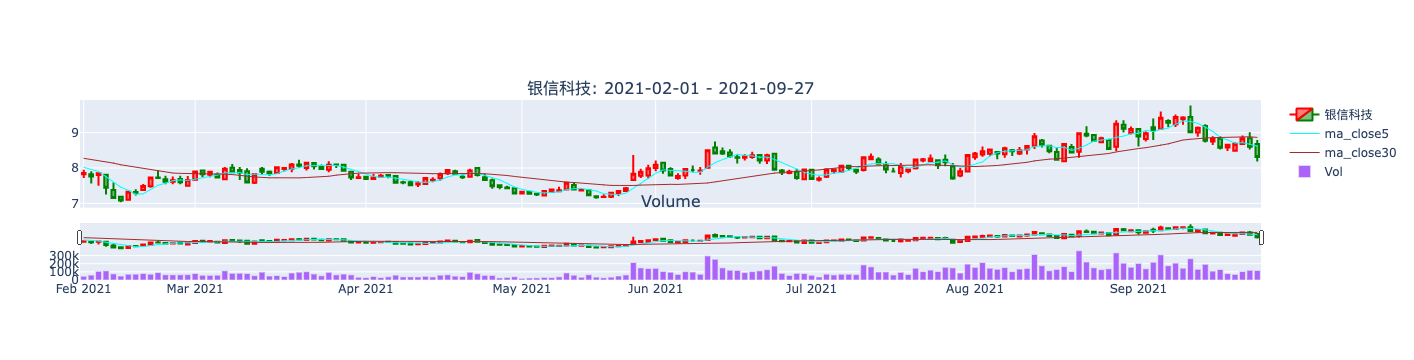

In [120]:
plot_k_plotly(df2.loc['300231.SZ']['2021-02-01':'2021-09-27'], ma_spans=[5,30])

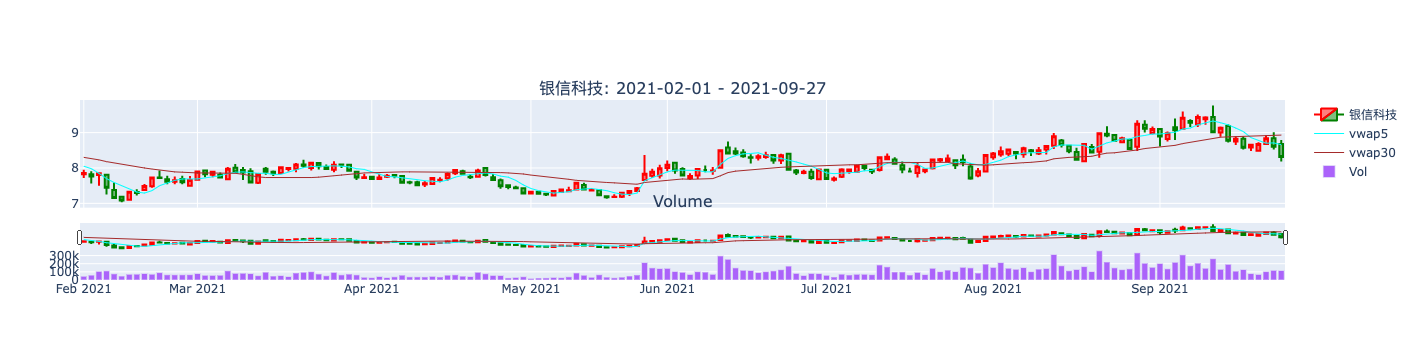

In [121]:
plot_k_plotly(df2.loc['300231.SZ']['2021-02-01':'2021-09-27'], ma_spans=[5,30], ma_col='vwap')

In [68]:
import bokeh.plotting as bplt
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file
from bokeh.palettes import Category20_20, Category20_16, inferno, magma
from bokeh.layouts import column, row, WidgetBox
from bokeh.models import Legend, Panel, ColumnDataSource, HoverTool, DatetimeTickFormatter
from bokeh.models.widgets import Tabs, CheckboxGroup, Slider, RangeSlider


def plot_mline(df, legend_labels, title, y_label, datespan=None, colors=None, w=800, h=450, verbose=False):
    summary = '''
        绘制单一 ts_code 的多指标线, 指标来自多个 column
    '''
    if verbose:
        print(summary)
    p = figure(plot_width=w, plot_height=h, title=title,
               x_axis_label= '交易日期', y_axis_label=y_label)
    p.xaxis[0].formatter = DatetimeTickFormatter()

    colors = Category20_16 if colors is None else colors
    legend_it=[]

    for legend, color in zip(legend_labels, colors):
        if datespan is not None:
            df=df[datespan].copy()
        c = p.line(df.index, df.loc[:,legend], line_width=2, color=color)
        legend_it.append((legend, [c]))

    legend = Legend(items=legend_it, location=(0, -60), click_policy='mute')
    p.add_layout(legend, 'right')
    show(p)


plot_mline(df3, legend_labels=['ma_close_5','vwap_5'], title='ma_v_vwap', y_label='Value')

In [15]:
import plotly.express as px

print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [135]:
test_stra_1 = {
    'name': 'Vibe',
    'filter': StockFilter(end_date).not_new().not_st(),
    'conditions':{
        'pre10_upstops': [
            {'op': '>', 'val': 1},
            {'op': '<', 'val': 4},
        ],
        'pre_ma_close_5': [
            {'op': '<', 'var': 'ma_close_5'}
        ],
        'pre2_ma_close_5': [
            {'op': '<', 'var': 'pre_ma_close_5'}
        ],
        'next_open_pct': [
            {'op': '<', 'val': 3},
            {'op': '>', 'val': -3}
        ],
        'close': {'op': '>', 'var': 'ma_close_5'},
        'pct_chg': [
            {'op': '>', 'val': 0},
            {'op': '<', 'val': 5}
        ]
    },
}

zhaban_stra = {
    'name': 'zhaban_v2',
    'filter': StockFilter(end_date).not_new().not_st(),
    
}

# 二：我自始至终觉得成交量这个指标非常重要，学会这点你将碾压80%的交易选手。
# 量比小于0.5，属于明显缩量，缩量能创新高，说明主力高度控盘，而且可以排除主力出货的可能，如果正好处于上升通道，则吃肉的概率极大。
# 如果股票涨停，量比小于1，说明还有较大的上涨空间，次日再次涨停的概率极大，
# 如果量比大于1.5，而且突破某个重要阻力位（比如20日均线）之后缩量回调的个股，是不可多得的买入对象。

# 四：早上大跌别急割，下午一般有反包，尾盘大涨要减仓，次日回调机率大。缩量上涨，还会上涨，缩量下跌，还会下跌，放量滞涨，头部已现，缩量止跌，底部已现，巨量急涨，必然回调，字字珠玑，成功率高达85%。

# 六：买入分歧，卖出一致，分歧产生溢价。这句话非常经典，我的体会就是当一个强势的股票出现分歧的时候，就是买点。分歧的表现就是连板的股票炸板，放量等特征，说明股票的多空双方的分歧比较大，出现分歧之后，后续继续上涨，当所有投资者都觉得还能继续上涨的时候，就是卖点。这里我总结一下做首阴反包要有几个要点：
# 1、要连板股，人气足，市场关注度高
# 2、首阴要杀得凶，市场分歧要足够大，对它能反包的市场预期不能太高
# 3、巨阴杀跌过程要满足两个条件：a.换手足 b.筹码换手要集中在杀跌当天的相对低位，否则会导致次日反包到高位时套牢盘的一致性卖压
# 4、巨阴杀跌次日出现意味着预期反转的超预期平开或者高开
# 5、首阴之日开始，调整不能超3个交易日，否则人气会逐渐涣散
# 如果以上五个条件都能满足到，那么该股的反包成功率会高很多。

In [145]:
x=pdl.parse(end_date)

In [159]:
end_date

'2021-09-17'

In [160]:
# tmpdf = StockFilter(end_date).not_st().filter(df).xs(slice('2021-06-20', '2021-09-17'), level=1, drop_level=False)
tmpdf = StockFilter(end_date).not_st().filter(df).xs(slice('2021-06-20', '2021-09-17'), level=1, drop_level=False)
tmp, keys = filter_by_strategy(tmpdf, test_stra_1['conditions'])
print(len(tmp))
tmp.drop(columns='name').join(dc.get_stock_basics()[['name']])[['name', 'pre10_upstops','ma_close_5', 'close', 'pct_chg', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']]

{'pre10_upstops': [{'op': '>', 'val': 1}, {'op': '<', 'val': 4}], 'pre_ma_close_5': [{'op': '<', 'var': 'ma_close_5'}], 'pre2_ma_close_5': [{'op': '<', 'var': 'pre_ma_close_5'}], 'next_open_pct': [{'op': '<', 'val': 3}, {'op': '>', 'val': -3}], 'close': {'op': '>', 'var': 'ma_close_5'}, 'pct_chg': [{'op': '>', 'val': 0}, {'op': '<', 'val': 5}]}
854


name  pre10_upstops  ma_close_5   close  pct_chg  \
ts_code   trade_date                                                     
000004.SZ 2021-07-16  国华网安            3.0      22.470   23.31   1.2598   
          2021-07-20  国华网安            3.0      24.148   25.97   1.2871   
000009.SZ 2021-06-21  中国宝安            2.0      15.298   16.24   1.4981   
          2021-08-10  中国宝安            2.0      25.138   25.59   0.2347   
000012.SZ 2021-07-15   南玻A            2.0      11.180   11.95   3.8228   
...                    ...            ...         ...     ...      ...   
688558.SH 2021-08-30  国盛智科            2.0      56.784   63.15   4.0020   
688595.SH 2021-07-26  芯海科技            2.0     127.542  134.62   1.9385   
688682.SH 2021-07-06   霍莱沃            2.0     143.088  165.87   1.6360   
          2021-07-07   霍莱沃            2.0     151.296  168.60   1.6459   
          2021-07-08   霍莱沃            2.0     162.522  173.78   3.0724   

                      next_open_pct  next_pct_chg  next2_pct_chg  
ts_code   trade_date                                              
000004.SZ 2021-07-16      -1.287001      9.995710      11.411411  
          2021-07-20       2.040816     -0.962649      -5.852907  
000009.SZ 2021-06-21       0.000000     -2.216749      -2.832512  
          2021-08-10      -2.227433     -1.641266      -4.337632  
000012.SZ 2021-07-15      -0.083682     -2.008368      -1.255230  
...                             ...           ...            ...  
688558.SH 2021-08-30      -0.633413     -0.712589      -5.922407  
688595.SH 2021-07-26       1.567375     -4.174714     -12.345862  
688682.SH 2021-07-06       0.078375      1.645867       4.768795  
          2021-07-07      -2.135231      3.072361      -9.845789  
          2021-07-08      -2.186673    -12.533088      -0.339510  

[854 rows x 8 columns]

In [149]:
tmp.xs('2021-09-13', level=1, drop_level=False)[['name', 'pre10_upstops','ma_close_5', 'close', 'pct_chg', 'next_open_pct', 'next_pct_chg', 'next2_pct_chg']]

KeyError: '2021-09-13'

In [114]:
tmp.next2_pct_chg.mean()

-0.3331060952892647

In [82]:
df.loc['603050.SH'][['name', 'pre10_upstops','ma_close_5', 'pre_ma_close_5', 'close', 'pct_chg']]

name  pre10_upstops  ma_close_5  pre_ma_close_5  close  pct_chg
trade_date                                                                 
2020-09-03  科林电气            NaN         NaN             NaN  13.64  -2.5299
2020-09-04  科林电气            NaN         NaN             NaN  13.76   0.8652
2020-09-07  科林电气            NaN         NaN             NaN  13.71  -0.3574
2020-09-08  科林电气            NaN         NaN             NaN  13.92   1.5065
2020-09-09  科林电气            NaN      13.778             NaN  13.86  -0.4240
...          ...            ...         ...             ...    ...      ...
2021-09-13  科林电气            NaN      17.260          16.892  17.67  -4.3831
2021-09-14  科林电气            NaN      17.526          17.260  17.21  -2.6033
2021-09-15  科林电气            NaN      17.614          17.526  17.91   4.0674
2021-09-16  科林电气            NaN      17.734          17.614  17.40  -2.8476
2021-09-17  科林电气            NaN      17.678          17.734  18.20   4.5977

[255 rows x 6 columns]

In [53]:
# missing: 鞍重股份(1 downstop), 银星能源
df.loc['603050.SH'][['name', 'pre10_upstops','ma_close_5', 'pre_ma_close_5', 'close', 'pct_chg']].tail(3)

name  pre10_upstops  ma_close_5  pre_ma_close_5  close  pct_chg
trade_date                                                                
2021-09-15  NaN            2.0      17.614          17.526  17.91   4.0674
2021-09-16  NaN            2.0      17.734          17.614  17.40  -2.8476
2021-09-17  NaN            2.0      17.678          17.734  18.20   4.5977

In [116]:
df_init.loc[:, 'open_pct'] = (df_init.open - df_init.pre_close)/df_init.pre_close * 100
df_init.loc[:, 'next_open_pct'] = df_init.groupby(level='ts_code').open_pct.shift(-1)

In [132]:
df.loc[:, 'pre10_upstops'] 

ts_code    trade_date
000001.SZ  2020-09-03   NaN
           2020-09-04   NaN
           2020-09-07   NaN
           2020-09-08   NaN
           2020-09-09   NaN
                         ..
689009.SH  2021-09-13   NaN
           2021-09-14   NaN
           2021-09-15   NaN
           2021-09-16   NaN
           2021-09-17   NaN
Name: pre10_upstops, Length: 1074066, dtype: float64

In [133]:
df.upstop_num.fillna(0, inplace=True)
df.loc[:, 'pre10_upstops'] = df.groupby(level='ts_code').upstop_num.apply(lambda x: x.rolling(window=10, min_periods=1).sum())
df.loc['603507.SH'][['pre10_upstops','limit','pct_chg','upstop_num']].tail(20)

pre10_upstops limit  pct_chg  upstop_num
trade_date                                          
2021-08-23            0.0   NaN   4.7775         0.0
2021-08-24            0.0   NaN   0.7658         0.0
2021-08-25            0.0   NaN  -0.9326         0.0
2021-08-26            0.0   NaN   0.6276         0.0
2021-08-27            0.0   NaN  -0.5544         0.0
2021-08-30            0.0   NaN   0.6620         0.0
2021-08-31            0.0   NaN   6.0921         0.0
2021-09-01            0.0   NaN  -4.0131         0.0
2021-09-02            1.0     U   9.9932         1.0
2021-09-03            2.0     U  10.0124         1.0
2021-09-06            3.0     U  10.0000         1.0
2021-09-07            3.0   NaN  -5.8223         0.0
2021-09-08            3.0   NaN  -8.1074         0.0
2021-09-09            3.0   NaN  -2.1245         0.0
2021-09-10            3.0   NaN  -4.5222         0.0
2021-09-13            4.0     U  10.0095         1.0
2021-09-14            4.0   NaN   1.8944         0.0
2021-09-15            5.0     U  10.0000         1.0
2021-09-16            4.0   NaN   4.4814         0.0
2021-09-17            3.0   NaN   0.6863         0.0

* 

In [13]:
df = gen_ma(df)
df.columns

Index(['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol',
       'amount', 'adj_factor', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'total_mv', 'circ_mv', 'total_share',
       'float_share', 'free_share', 'last_factor', 'pre_close_4',
       'pre_close_6', 'pre_close_11', 'pre_close_21', 'pre_pct_chg',
       'pre3_pct_chg', 'pre5_pct_chg', 'pre10_pct_chg', 'pre20_pct_chg',
       'next_close_1', 'next_close_2', 'next_close_3', 'next_close_10',
       'next_close_20', 'next_pct_chg', 'next2_pct_chg', 'next3_pct_chg',
       'next10_pct_chg', 'next20_pct_chg', 'max_pre60_close',
       'max_pre120_close', 'open_preclose_pct', 'ma_vol_5', 'ma_vol_20',
       'vol_ratio', 'vol_ratio_long', 'vol_type', 'pre_vol_type', 'buy_sm_vol',
       'buy_md_vol', 'buy_lg_vol', 'buy_elg_vol', 'sell_sm_vol', 'sell_md_vol',
       'sell_lg_vol', 'sell_elg_vol', 'buy_sm_amount', 'buy_md_amount',
       'buy_lg_amount', 'buy_elg_amount', 'sell_sm_amou

In [15]:
df = gen_ma(df)
df.loc[:,'pre_ma_close_5'] = df.groupby(level='ts_code').ma_close_5.shift(1)
df.loc[:,'pre2_ma_close_5'] = df.groupby(level='ts_code').ma_close_5.shift(2)

In [12]:
df = gen_ma(df)
df

Index(['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol',
       'amount', 'adj_factor', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'total_mv', 'circ_mv', 'total_share',
       'float_share', 'free_share', 'last_factor', 'pre_close_4',
       'pre_close_6', 'pre_close_11', 'pre_close_21', 'pre_pct_chg',
       'pre3_pct_chg', 'pre5_pct_chg', 'pre10_pct_chg', 'pre20_pct_chg',
       'next_close_1', 'next_close_2', 'next_close_3', 'next_close_10',
       'next_close_20', 'next_pct_chg', 'next2_pct_chg', 'next3_pct_chg',
       'next10_pct_chg', 'next20_pct_chg', 'max_pre60_close',
       'max_pre120_close', 'open_preclose_pct', 'ma_vol_5', 'ma_vol_20',
       'vol_ratio', 'vol_ratio_long', 'vol_type', 'pre_vol_type', 'buy_sm_vol',
       'buy_md_vol', 'buy_lg_vol', 'buy_elg_vol', 'sell_sm_vol', 'sell_md_vol',
       'sell_lg_vol', 'sell_elg_vol', 'buy_sm_amount', 'buy_md_amount',
       'buy_lg_amount', 'buy_elg_amount', 'sell_sm_amou

In [66]:
df_end[df_end.upstop_num==1]

open    high     low   close  pre_close  change  \
ts_code   trade_date                                                      
000155.SZ 2021-09-17   34.10   37.33   32.68   37.33      33.94    3.39   
000516.SZ 2021-09-17   10.46   11.03   10.35   11.03      10.03    1.00   
000525.SZ 2021-09-17    5.70    5.96    5.65    5.96       5.68    0.28   
000537.SZ 2021-09-17   12.00   12.50   12.00   12.50      11.36    1.14   
000564.SZ 2021-09-17    3.21    3.21    3.21    3.21       3.06    0.15   
000587.SZ 2021-09-17    1.52    1.59    1.52    1.59       1.51    0.08   
000731.SZ 2021-09-17   12.56   12.56   12.56   12.56      11.42    1.14   
000791.SZ 2021-09-17    5.80    6.41    5.77    6.41       5.83    0.58   
000799.SZ 2021-09-17  228.99  254.46  228.78  254.46     231.33   23.13   
000912.SZ 2021-09-17    6.85    7.88    6.82    7.88       7.16    0.72   
000920.SZ 2021-09-17   11.24   12.33   11.09   12.33      11.21    1.12   
001215.SZ 2021-09-17   53.34   53.34   53.34   53.34      48.49    4.85   
001896.SZ 2021-09-17    9.53   10.48    9.29   10.48       9.53    0.95   
002005.SZ 2021-09-17    2.01    2.10    1.95    2.10       2.00    0.10   
002039.SZ 2021-09-17   21.75   23.75   21.69   23.75      21.59    2.16   
002153.SZ 2021-09-17   19.46   19.46   19.46   19.46      17.69    1.77   
002165.SZ 2021-09-17    8.31    8.31    8.31    8.31       7.55    0.76   
002175.SZ 2021-09-17    2.54    2.65    2.51    2.65       2.52    0.13   
002200.SZ 2021-09-17    8.44    8.82    8.32    8.82       8.40    0.42   
002259.SZ 2021-09-17    3.68    3.74    3.54    3.74       3.56    0.18   
002288.SZ 2021-09-17    9.40   10.41    9.12   10.41       9.46    0.95   
002323.SZ 2021-09-17    4.22    4.44    4.20    4.44       4.23    0.21   
002487.SZ 2021-09-17   18.36   21.02   18.00   21.02      19.11    1.91   
002637.SZ 2021-09-17   18.50   19.50   18.16   19.50      17.73    1.77   
002699.SZ 2021-09-17    4.30    4.73    4.29    4.73       4.30    0.43   
002980.SZ 2021-09-17   32.60   34.57   31.60   34.57      31.43    3.14   
300402.SZ 2021-09-17   22.12   25.21   22.00   25.21      21.01    4.20   
300569.SZ 2021-09-17   10.76   12.85   10.76   12.85      10.71    2.14   
300610.SZ 2021-09-17   18.40   22.60   18.27   22.60      18.83    3.77   
300772.SZ 2021-09-17   48.20   57.84   48.20   57.84      48.20    9.64   
300969.SZ 2021-09-17   57.68   68.68   57.20   68.68      57.23   11.45   
301049.SZ 2021-09-17   38.39   41.74   38.39   41.74      34.78    6.96   
600021.SH 2021-09-17    8.67    9.57    8.66    9.57       8.70    0.87   
600032.SH 2021-09-17   12.60   13.45   12.37   13.45      12.23    1.22   
600163.SH 2021-09-17    7.55    8.25    7.55    8.25       7.50    0.75   
600199.SH 2021-09-17   15.01   16.69   14.85   16.69      15.17    1.52   
600221.SH 2021-09-17    2.06    2.18    2.06    2.18       2.08    0.10   
600291.SH 2021-09-17    4.63    4.90    4.53    4.90       4.67    0.23   
600385.SH 2021-09-17    6.06    6.30    6.00    6.30       6.00    0.30   
600470.SH 2021-09-17    9.80   10.80    9.50   10.80       9.82    0.98   
600483.SH 2021-09-17   15.17   16.74   15.13   16.74      15.22    1.52   
600595.SH 2021-09-17    4.53    4.76    4.44    4.76       4.53    0.23   
600695.SH 2021-09-17    4.27    4.49    4.11    4.49       4.28    0.21   
600763.SH 2021-09-17  255.67  282.04  248.88  282.04     256.40   25.64   
600821.SH 2021-09-17    6.77    7.33    6.69    7.33       6.66    0.67   
600863.SH 2021-09-17    3.34    3.67    3.33    3.67       3.34    0.33   
600905.SH 2021-09-17    5.99    6.62    5.98    6.62       6.02    0.60   
600955.SH 2021-09-17   51.51   51.51   51.51   51.51      46.83    4.68   
601016.SH 2021-09-17    5.82    6.42    5.72    6.42       5.84    0.58   
601567.SH 2021-09-17   13.44   15.11   13.24   15.11      13.74    1.37   
603079.SH 2021-09-17   17.60   18.61   16.79   18.61      16.92    1.69   
603351.SH 2021-09-17   27.22   29.90   27.22   29